In [1]:
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torchvision import transforms  # ‚úÖ Ïù¥Í±∏ Ï∂îÍ∞ÄÌï¥Ïïº transforms ÏÇ¨Ïö© Í∞ÄÎä•!
import torch
import torch.nn as nn

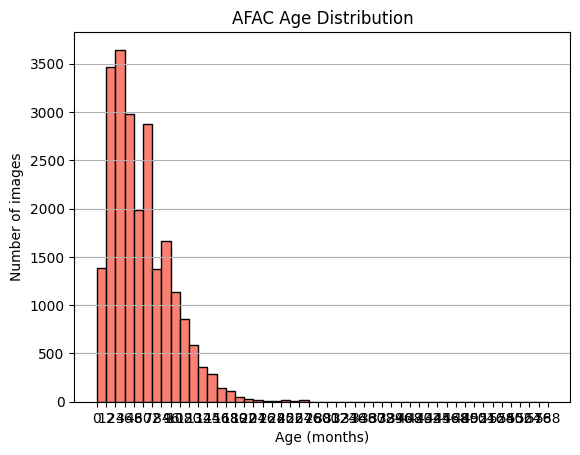

In [1]:
import matplotlib.pyplot as plt

# Age Î∂ÑÌè¨ Îã§Ïãú ÏãúÍ∞ÅÌôî
with open('AFAC/annotations/train.txt', 'r') as f:
    ages = []
    for line in f:
        try:
            _, age_str = line.strip().split()
            ages.append(int(age_str))
        except:
            continue

plt.hist(ages, bins=range(0, max(ages)+12, 12), color='salmon', edgecolor='black')
plt.xlabel("Age (months)")
plt.ylabel("Number of images")
plt.title("AFAC Age Distribution")
plt.grid(axis='y')
plt.xticks(range(0, max(ages)+12, 12))
plt.show()

‚ö†Ô∏è ÏûòÎ™ªÎêú ÎùºÏù∏ Î¨¥Ïãú: 
‚úÖ ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨ (3-Class Í∏∞Ï§Ä):
Young: 11629Í∞ú
Senior: 5292Í∞ú
Middle: 6079Í∞ú


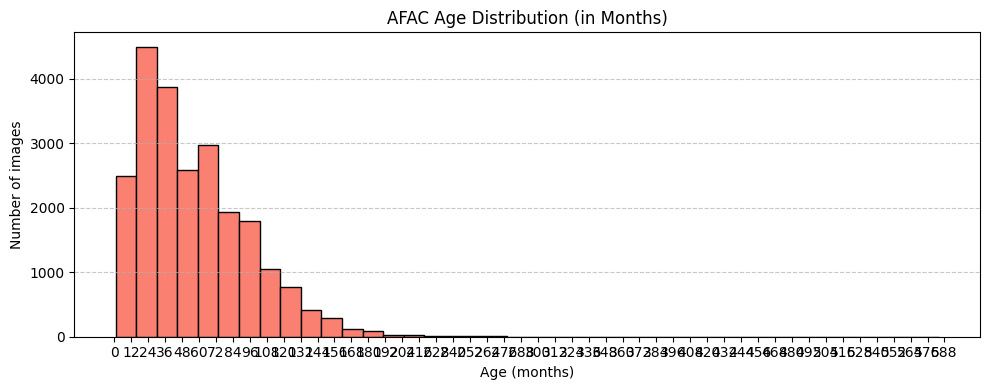

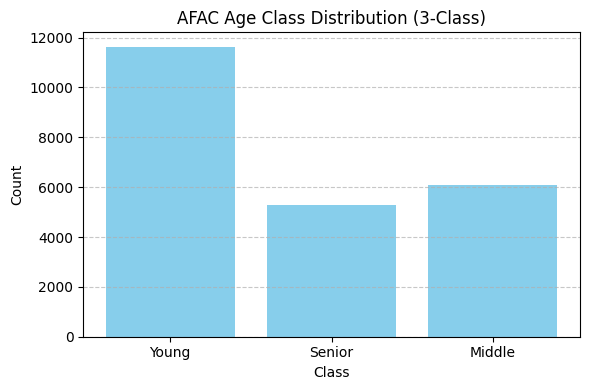

In [2]:
from collections import Counter
import matplotlib.pyplot as plt

# Í≤ΩÎ°ú
txt_path = "AFAC/annotations/train.txt"

# ÎÇòÏù¥ ‚Üí ÌÅ¥ÎûòÏä§ Ìï®Ïàò (3-class)
def age_to_class(age_months):
    if age_months <= 48:
        return "Young"
    elif age_months <= 83:
        return "Middle"
    else:
        return "Senior"

# Ïπ¥Ïö¥Ìä∏Ïö© Î¶¨Ïä§Ìä∏
age_classes = []
age_raw = []

with open(txt_path, 'r') as f:
    for line in f:
        try:
            _, age_str = line.strip().split()
            age = int(age_str)
            age_raw.append(age)
            age_classes.append(age_to_class(age))
        except:
            print(f"‚ö†Ô∏è ÏûòÎ™ªÎêú ÎùºÏù∏ Î¨¥Ïãú: {line.strip()}")

# ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨ Ï∂úÎ†•
class_counts = Counter(age_classes)
print("‚úÖ ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨ (3-Class Í∏∞Ï§Ä):")
for cls, count in class_counts.items():
    print(f"{cls}: {count}Í∞ú")

# ÏãúÍ∞ÅÌôî: Ïó∞Î†π Î∂ÑÌè¨ ÌûàÏä§ÌÜ†Í∑∏Îû®
plt.figure(figsize=(10, 4))
plt.hist(age_raw, bins=40, color='salmon', edgecolor='black')
plt.title("AFAC Age Distribution (in Months)")
plt.xlabel("Age (months)")
plt.ylabel("Number of images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, max(age_raw)+12, 12))
plt.tight_layout()
plt.show()

# ÏãúÍ∞ÅÌôî: ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("AFAC Age Class Distribution (3-Class)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [3]:
# ================================
# üê∂ AFAC Dataset - Age-based Class Reassignment (2-Class)
# ================================

# üìå Î™©Ìëú:
#   - Í∞ïÏïÑÏßÄÏùò "ÎÖ∏Ìôî(Aging)"Î•º ÏÉùÏÑ± Î™®Îç∏Ïù¥ Ï†ïÌôïÌûà ÌïôÏäµÌïòÎèÑÎ°ù ÌÅ¥ÎûòÏä§ Î∂ÑÎ¶¨
#   - Identity Î≥¥Ï°¥Í≥º Ìï®Íªò ÏãúÍ∞ÅÏ†ÅÏúºÎ°ú Ï∞®Î≥ÑÎêòÎäî ÎÖ∏Ìôî Ï°∞Í±¥ÏùÑ ÎßåÎì§Í∏∞ ÏúÑÌï®

# üìä ÎèÑÎ©îÏù∏ ÏßÄÏãù Í∏∞Î∞ò ÏÜåÌòïÍ≤¨Ïùò ÎÖ∏Ìôî Í≥ºÏ†ï:
#   - 0‚Äì12Í∞úÏõî: Puppy ‚Üí Ïô∏ÌòïÏ†ÅÏúºÎ°ú Î™ÖÌôïÌûà Í∑ÄÏó¨Ïö¥ ÌòïÌÉú
#   - 1‚Äì3ÏÑ∏ (‚â§ 48Í∞úÏõî): Ïó¨Ï†ÑÌûà Ï†äÏùÄ ÏÑ±Í≤¨ ‚Üí "Young"ÏúºÎ°ú Í∞ÑÏ£º
#   - 4‚Äì6ÏÑ∏ (49‚Äì83Í∞úÏõî): Ïô∏Ìòï Î≥ÄÌôî Ïï†Îß§Ìïú Í≥ºÎèÑÍ∏∞ ‚Üí Î™®Îç∏ ÌïôÏäµÏóê ÌòºÎûÄ Ïú†Î∞ú
#   - 7ÏÑ∏ Ïù¥ÏÉÅ (‚â• 84Í∞úÏõî): Senior, Ïô∏ÌòïÏ†ÅÏúºÎ°ú ÌôïÏã§Ìïú ÎÖ∏Ìôî ÏßïÌõÑ ‚Üí Îàà, ÌÑ∏ÏÉâ Îì±

# ‚úÖ ÌÅ¥ÎûòÏä§ Ïû¨Ï†ïÏùò:
#   - "Young": ‚â§ 48Í∞úÏõî (0~4ÏÑ∏)
#   - "Senior": ‚â• 84Í∞úÏõî (7ÏÑ∏ Ïù¥ÏÉÅ)
#   - ÎÇòÎ®∏ÏßÄ (49‚Äì83Í∞úÏõî)Îäî "Middle"Î°ú Í∞ÑÏ£º ‚Üí ÌïôÏäµÏóêÏÑú Ï†úÏô∏

# üß† Ïôú Middle Ï†úÍ±∞?
#   - ÏãúÍ∞ÅÏ†ÅÏúºÎ°ú Íµ¨Î∂ÑÏù¥ Î™®Ìò∏Ìï®
#   - Î™®Îç∏Ïù¥ "Í∑∏Îü¥ÎìØÌïú ÏñºÍµ¥"ÏùÑ ÏÉùÏÑ±ÌïòÎ†§Îã§ identityÎ•º Î∞îÍøîÎ≤ÑÎ¶¨Îäî Í≤ΩÌñ•
#   - Disentangled Ï°∞Í±¥ ÌïôÏäµÏóê Î∞©Ìï¥

# ‚úÖ Í∏∞ÎåÄ Ìö®Í≥º:
#   - Young ‚Üî Senior Í∞Ñ Î™ÖÌôïÌïú Î≥ÄÌòï Ï°∞Í±¥
#   - Îçî ÎÇòÏùÄ ÌíàÏßàÏùò aging generation
#   - identity Î≥¥Ï°¥ Ïö©Ïù¥

In [4]:
import os
from collections import Counter

# üìç ÏõêÎ≥∏ train.txt Í≤ΩÎ°ú
train_txt_path = "AFAC/annotations/train.txt"

# üìç Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏûàÎäî Í≤ΩÎ°ú
image_root = "AFAC/trainset"

# üìç Ï†ÄÏû•Ìï† Í≤ΩÎ°ú
save_txt_path = "AFAC/AFAC.txt"

# üîπ ÎÇòÏù¥ ‚Üí ÌÅ¥ÎûòÏä§ Îß§Ìïë (domain knowledge Í∏∞Î∞ò)
def age_to_class(age_months):
    if age_months <= 48:
        return "Young"
    elif age_months >= 84:
        return "Senior"
    else:
        return "Middle"  # ÎÇòÏ§ëÏóê Ï†úÍ±∞Ìï† ÎåÄÏÉÅ

# üîπ Ïú†Ìö®Ìïú Î†àÏΩîÎìú Ï†ÄÏû•
records = []
class_counts = Counter()

with open(train_txt_path, "r") as f:
    for line in f:
        try:
            filename, age_str = line.strip().split()
            age = int(age_str)
            label = age_to_class(age)

            if label == "Middle":
                continue  # ‚ùå Middle Ï†úÍ±∞

            # Ìï¥Îãπ ÌååÏùºÏù¥ Ïã§Ï†úÎ°ú Ï°¥Ïû¨ÌïòÎäîÏßÄ ÌôïÏù∏
            image_path = os.path.join(image_root, filename)
            if not os.path.isfile(image_path):
                print(f"‚ö†Ô∏è Ïù¥ÎØ∏ÏßÄ ÎàÑÎùΩ: {filename}")
                continue

            records.append((filename, label))
            class_counts[label] += 1
        except:
            print(f"‚ö†Ô∏è ÏûòÎ™ªÎêú ÎùºÏù∏ Î¨¥Ïãú: {line.strip()}")

# üîπ AFAC.txt Ï†ÄÏû•
with open(save_txt_path, "w") as f:
    for filename, label in records:
        f.write(f"{filename}\t{label}\n")

# üîπ ÌÜµÍ≥Ñ Ï∂úÎ†•
print(f"\n‚úÖ {len(records)}Í∞ú ÏÉòÌîåÏù¥ {save_txt_path}Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
print("\nüìä ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨ (Middle Ï†úÍ±∞ ÌõÑ):")
for cls in ["Young", "Senior"]:
    print(f"{cls}: {class_counts[cls]}Í∞ú")

‚ö†Ô∏è ÏûòÎ™ªÎêú ÎùºÏù∏ Î¨¥Ïãú: 

‚úÖ 16921Í∞ú ÏÉòÌîåÏù¥ AFAC/AFAC.txtÏóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.

üìä ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨ (Middle Ï†úÍ±∞ ÌõÑ):
Young: 11629Í∞ú
Senior: 5292Í∞ú


In [25]:
import shutil

# ÎîîÎ†âÌÜ†Î¶¨ ÏÇ≠Ï†ú
preprocessed_dir = "AFAC/preprocessed"
shutil.rmtree(preprocessed_dir)
print(f"üóëÔ∏è ÏÇ≠Ï†ú ÏôÑÎ£å: {preprocessed_dir}")

üóëÔ∏è ÏÇ≠Ï†ú ÏôÑÎ£å: AFAC/preprocessed


In [26]:
import os
from PIL import Image
from tqdm import tqdm

import torch
from torchvision import transforms

# Í≤ΩÎ°ú ÏÑ§Ï†ï
input_dir = 'AFAC/trainset'
output_dir = 'AFAC/preprocessed'
os.makedirs(output_dir, exist_ok=True)

# Ï†ÑÏ≤òÎ¶¨ ÌååÏù¥ÌîÑÎùºÏù∏ Ï†ïÏùò (‚ùå Normalize Ï†úÍ±∞Îê®!)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # 1. Ï†ïÏÇ¨Í∞ÅÌòïÏúºÎ°ú resize

    # 2. Custom Crop: ÏúÑÏ™Ω Ï°∞Í∏à Îçî ÏûêÎ•¥Í≥† Ï§ëÏã¨ ÏïÑÎûòÎ°ú Ïù¥Îèô
    transforms.Lambda(lambda img: img.crop((
        16,    # left
        12,    # top
        240,   # right = left + 224
        236    # bottom = top + 224
    ))),

    # 3. ÏïΩÌïú Color Jitter (Î∞∞Í≤Ω Ï°∞ÎèÑ Î≥¥ÏôÑÏö©)
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.05,
        saturation=0.1,
        hue=0.02
    ),

    # 4. ÏàòÌèâ Îí§ÏßëÍ∏∞
    transforms.RandomHorizontalFlip(p=0.5),

    # 5. ÌÖêÏÑú Î≥ÄÌôò (Ï†ïÍ∑úÌôî ÏóÜÏùå!)
    transforms.ToTensor()
])

# Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ Ïã§Ìñâ
image_paths = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png'))]

for filename in tqdm(image_paths, desc="üì¶ Preprocessing AFAC"):
    try:
        img = Image.open(os.path.join(input_dir, filename)).convert('RGB')
        processed = preprocess(img)
        output_path = os.path.join(output_dir, filename.replace(".png", ".jpg"))
        transforms.ToPILImage()(processed).save(output_path)
    except Exception as e:
        print(f"‚ùå {filename} Ï≤òÎ¶¨ Ïã§Ìå®: {e}")

üì¶ Preprocessing AFAC: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 22994/22994 [05:24<00:00, 70.93it/s]


In [27]:
len([f for f in os.listdir("AFAC/trainset") if f.lower().endswith((".jpg", ".jpeg", ".png"))]) 

22995

In [3]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=100, c_dim=2):
        super().__init__()
        self.fc = nn.Linear(z_dim + c_dim, 1024 * 4 * 4)

        self.net = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            # 4√ó4 ‚Üí 8√ó8
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # 8√ó8 ‚Üí 16√ó16
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # 16√ó16 ‚Üí 32√ó32
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 32√ó32 ‚Üí 64√ó64
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 64√ó64 ‚Üí 128√ó128
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, z, c):
        x = torch.cat([z, c], dim=1)         # [B, z_dim + c_dim]
        x = self.fc(x)                       # [B, 1024 * 4 * 4]
        x = x.view(-1, 1024, 4, 4)           # [B, 1024, 4, 4]
        return self.net(x)                   # [B, 3, 128, 128]

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InjectionGenerator(nn.Module):
    def __init__(self, z_dim=128, c_dim=2):
        super().__init__()
        self.fc = nn.Linear(z_dim + c_dim, 1024 * 4 * 4)

        # condition inject layers (ÏÑ†ÌÉùÎêú 2Í∞úÎßå)
        self.inject_c1 = nn.Linear(c_dim, 512)
        self.inject_c2 = nn.Linear(c_dim, 256)

        # deconv blocks
        self.net = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1),   # 4√ó4 ‚Üí 8√ó8
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),    # 8√ó8 ‚Üí 16√ó16
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),    # 16√ó16 ‚Üí 32√ó32
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),     # 32√ó32 ‚Üí 64√ó64
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),       # 64√ó64 ‚Üí 128√ó128
            nn.Tanh()
        )

    def forward(self, z, c):
        x = torch.cat([z, c], dim=1)             # [B, z_dim + c_dim]
        x = self.fc(x).view(-1, 1024, 4, 4)      # [B, 1024, 4, 4]

        # Initial batchnorm + relu
        x = self.net[0](x)
        x = self.net[1](x)

        # Block 1: 4x4 ‚Üí 8x8 + c inject
        x = self.net[2](x)
        x += self.inject_c1(c).view(-1, 512, 1, 1)
        x = self.net[3](x)
        x = self.net[4](x)

        # Block 2: 8x8 ‚Üí 16x16 + c inject
        x = self.net[5](x)
        x += self.inject_c2(c).view(-1, 256, 1, 1)
        x = self.net[6](x)
        x = self.net[7](x)

        # Block 3: 16x16 ‚Üí 32x32
        x = self.net[8](x)
        x = self.net[9](x)
        x = self.net[10](x)

        # Block 4: 32x32 ‚Üí 64x64
        x = self.net[11](x)
        x = self.net[12](x)
        x = self.net[13](x)

        # Output: 64x64 ‚Üí 128x128 ‚Üí Tanh
        x = self.net[14](x)
        x = self.net[15](x)

        return x

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConcatGenerator(nn.Module):
    def __init__(self, z_dim=128, c_dim=2, c_emb_dim=16):
        super().__init__()
        self.c_emb = nn.Linear(c_dim, c_emb_dim)             # üîπ 2 ‚Üí 16
        self.fc = nn.Linear(z_dim + c_emb_dim, 1024 * 4 * 4)  # z + c_emb

        # üîπ condition injection (block 2Îßå)
        self.inject_c = nn.Linear(c_emb_dim, 256)

        # üîπ deconv blocks
        self.net = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1),   # 4x4 ‚Üí 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),    # 8x8 ‚Üí 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),    # 16x16 ‚Üí 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),     # 32x32 ‚Üí 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),       # 64x64 ‚Üí 128x128
            nn.Tanh()
        )

    def forward(self, z, c):
        # üîπ Embed condition
        c_emb = self.c_emb(c)  # [B, 16]

        # üîπ Initial projection
        x = torch.cat([z, c_emb], dim=1)              # [B, z + c_emb]
        x = self.fc(x).view(-1, 1024, 4, 4)

        # üîπ Block 1: 4x4 ‚Üí 8x8
        x = self.net[0](x)
        x = self.net[1](x)

        x = self.net[2](x)
        x = self.net[3](x)
        x = self.net[4](x)

        # üîπ Block 2: 8x8 ‚Üí 16x16 + condition inject
        x = self.net[5](x)
        x += self.inject_c(c_emb).view(-1, 256, 1, 1)  # üí° Îã® Ìïú Î≤àÎßå Ï£ºÏûÖ
        x = self.net[6](x)
        x = self.net[7](x)

        # üîπ Block 3: 16x16 ‚Üí 32x32
        x = self.net[8](x)
        x = self.net[9](x)
        x = self.net[10](x)

        # üîπ Block 4: 32x32 ‚Üí 64x64
        x = self.net[11](x)
        x = self.net[12](x)
        x = self.net[13](x)

        # üîπ Output: 64x64 ‚Üí 128x128
        x = self.net[14](x)
        x = self.net[15](x)

        return x

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm as SN

class ProjectionDiscriminator(nn.Module):
    def __init__(self, c_dim=2, img_channels=3):
        super().__init__()
        self.c_dim = c_dim

        self.feature_extractor = nn.Sequential(
            SN(nn.Conv2d(img_channels, 64, 4, 2, 1)),   # 128 ‚Üí 64
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(64, 128, 4, 2, 1)),             # 64 ‚Üí 32
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(128, 256, 4, 2, 1)),            # 32 ‚Üí 16
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(256, 512, 4, 2, 1)),            # 16 ‚Üí 8
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(512, 512, 4, 2, 1)),            # 8 ‚Üí 4
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(512, 512, 4, 2, 1)),            # 4 ‚Üí 2
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(512, 512, 2, 1, 0)),            # 2 ‚Üí 1
        )

        self.linear = SN(nn.Linear(512, 1))              # unconditional logit
        self.embed = SN(nn.Embedding(c_dim, 512))        # class embedding (same dim as features)

    def forward(self, x, c):
        """
        x: [B, 3, 128, 128]
        c: [B] (LongTensor class label)
        """
        features = self.feature_extractor(x)             # [B, 512, 1, 1]
        features = features.view(x.size(0), -1)          # [B, 512]

        out = self.linear(features)                      # [B, 1]
        emb = self.embed(c)                              # [B, 512]
        proj = torch.sum(features * emb, dim=1, keepdim=True)  # [B, 1]

        return out + proj                                # [B, 1]

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm as SN

class ConcatDiscriminator(nn.Module):
    def __init__(self, c_dim=2, img_channels=3, embed_dim=16):
        super().__init__()
        self.c_dim = c_dim

        # ‚öôÔ∏è Feature extractor
        self.feature_extractor = nn.Sequential(
            SN(nn.Conv2d(img_channels, 64, 4, 2, 1)),   # 128 ‚Üí 64
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(64, 128, 4, 2, 1)),             # 64 ‚Üí 32
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(128, 256, 4, 2, 1)),            # 32 ‚Üí 16
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(256, 512, 4, 2, 1)),            # 16 ‚Üí 8
            nn.LeakyReLU(0.2, inplace=True),

            SN(nn.Conv2d(512, 512, 8, 1, 0)),            # 8√ó8 ‚Üí 1√ó1
            nn.LeakyReLU(0.2, inplace=True),
        )

        # ‚öôÔ∏è Class embedding
        self.embed = nn.Linear(c_dim, embed_dim)         # e.g. 2 ‚Üí 16

        # ‚öôÔ∏è Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + embed_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, x, c):
        """
        x: [B, 3, 128, 128]
        c: [B, c_dim] (e.g. one-hot)
        """
        B = x.size(0)
        features = self.feature_extractor(x)             # [B, 512, 1, 1]
        features = features.view(B, -1)                  # [B, 512]

        c_emb = self.embed(c)                            # [B, embed_dim]
        concat = torch.cat([features, c_emb], dim=1)     # [B, 512 + embed_dim]

        out = self.classifier(concat)                    # [B, 1]
        return out

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self, c_dim=2, img_channels=3):
        super().__init__()
        self.c_dim = c_dim  # for one-hot

        self.net = nn.Sequential(
            # Input: [B, 3 + c_dim, 128, 128]
            nn.Conv2d(img_channels + c_dim, 64, 4, 2, 1),   # 64√ó64
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),                    # 32√ó32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),                   # 16√ó16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1),                   # 8√ó8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 8),                           # 1√ó1
        )

    def forward(self, x, c):
        """
        x: [B, 3, 128, 128]
        c: [B] (LongTensor class label)
        """
        B, _, H, W = x.shape
        c_onehot = F.one_hot(c, num_classes=self.c_dim).float()  # [B, c_dim]
        c_map = c_onehot.view(B, self.c_dim, 1, 1).expand(B, self.c_dim, H, W)  # [B, c_dim, H, W]
        x_cond = torch.cat([x, c_map], dim=1)  # [B, 3 + c_dim, H, W]
        out = self.net(x_cond)                 # [B, 1, 1, 1]
        return out.view(-1, 1)                 # [B, 1]

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class AFACDataset(Dataset):
    def __init__(self, txt_path, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        self.samples = []
        self.label_map = {'Young': 0, 'Senior': 1}
        self.missing_files = []

        # 1. ÌÖçÏä§Ìä∏ÏóêÏÑú Î†àÏù¥Î∏î Î∂àÎü¨Ïò§Í∏∞
        with open(txt_path, 'r') as f:
            for line in f:
                filename, label = line.strip().split('\t')

                # 2. Ïù¥ÎØ∏ÏßÄÍ∞Ä Ïã§Ï†ú Ï°¥Ïû¨ÌïòÎäîÏßÄ ÌôïÏù∏
                img_path = os.path.join(img_dir, filename)
                if os.path.exists(img_path):
                    self.samples.append((filename, label))
                else:
                    self.missing_files.append(filename)

        print(f"‚úÖ Ï¥ù Î°úÎìúÎêú ÏÉòÌîå Ïàò: {len(self.samples)}")
        if self.missing_files:
            print(f"‚ö†Ô∏è ÎàÑÎùΩÎêú Ïù¥ÎØ∏ÏßÄ ÌååÏùº Ïàò: {len(self.missing_files)}")
            print(f"ÏòàÏãú ÎàÑÎùΩ ÌååÏùºÎ™Ö: {self.missing_files[:5]}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filename, label = self.samples[idx]
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label_idx = self.label_map[label]
        return image, label_idx

In [8]:
txt_path = "AFAC/AFAC.txt"
img_dir = "AFAC/preprocessed"

dataset = AFACDataset(txt_path, img_dir, transform=None)

‚úÖ Ï¥ù Î°úÎìúÎêú ÏÉòÌîå Ïàò: 16920
‚ö†Ô∏è ÎàÑÎùΩÎêú Ïù¥ÎØ∏ÏßÄ ÌååÏùº Ïàò: 1
ÏòàÏãú ÎàÑÎùΩ ÌååÏùºÎ™Ö: ['O1CN01DYF38A20tSMfFRYma_!!6000000006907-0-antinsbiocamera.jpeg']


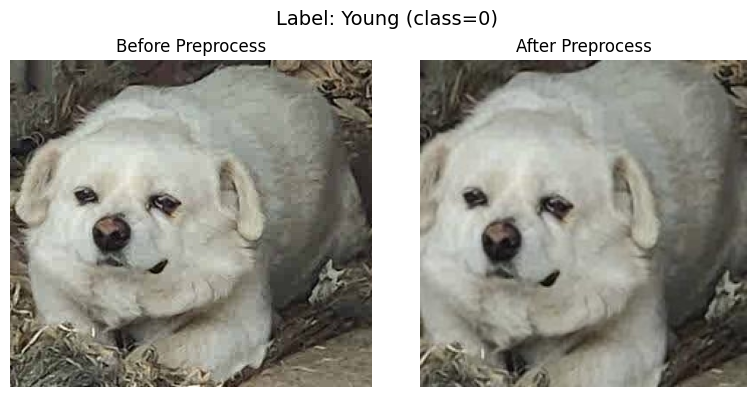

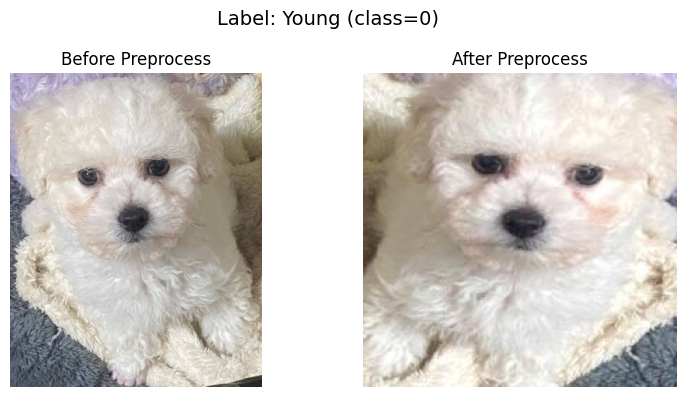

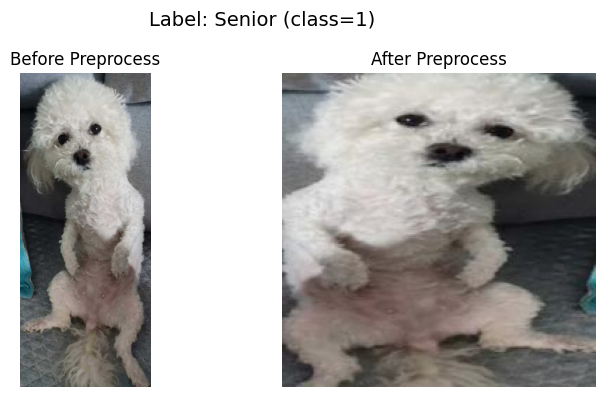

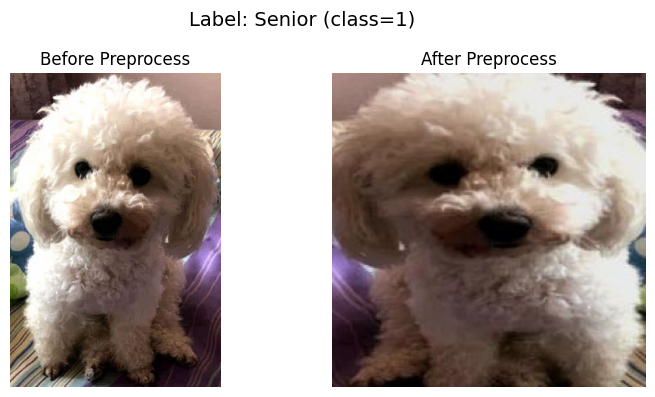

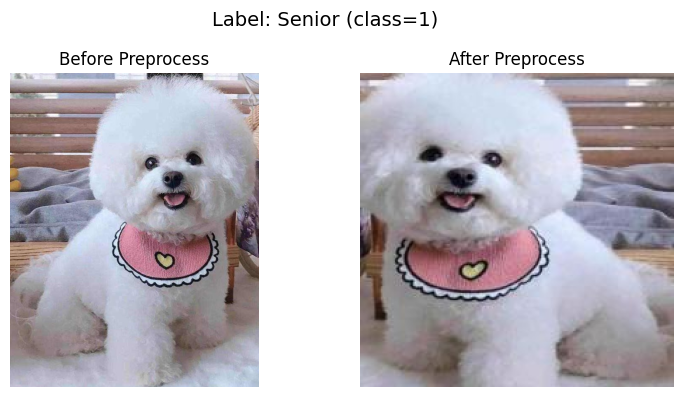

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision import transforms
from tqdm import tqdm

# Í≤ΩÎ°ú ÏÑ§Ï†ï
txt_path = 'AFAC/AFAC.txt'
raw_dir = 'AFAC/trainset'
pre_dir = 'AFAC/preprocessed'

# ÌÖêÏÑúÎ•º PILÎ°ú Î≥ÄÌôò
to_pil = ToPILImage()

# ÎùºÎ≤® Îß§Ìïë
label_map = {'Young': 0, 'Senior': 1}

# AFAC.txtÏóêÏÑú ÏÉòÌîå Î°úÎìú
samples = []
with open(txt_path, 'r') as f:
    for line in f:
        filename, label = line.strip().split('\t')
        samples.append((filename, label_map[label]))

# ÏãúÍ∞ÅÌôî
for i in range(5):
    filename, label = samples[i]

    # ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ
    raw_img = Image.open(os.path.join(raw_dir, filename)).convert('RGB')

    # Ï†ÑÏ≤òÎ¶¨ Ïù¥ÎØ∏ÏßÄ (Ïù¥ÎØ∏ TensorÎ°ú Ï†ÄÏû•Îêú Í±¥ ÏïÑÎãò)
    pre_img_path = os.path.join(pre_dir, filename.replace('.png', '.jpg'))
    pre_img = Image.open(pre_img_path).convert('RGB')

    # ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(8, 4))
    plt.suptitle(f"Label: {'Young' if label == 0 else 'Senior'} (class={label})", fontsize=14)

    plt.subplot(1, 2, 1)
    plt.imshow(raw_img)
    plt.title('Before Preprocess')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pre_img)
    plt.title('After Preprocess')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

‚úÖ Ï¥ù Î°úÎìúÎêú ÏÉòÌîå Ïàò: 16920
‚ö†Ô∏è ÎàÑÎùΩÎêú Ïù¥ÎØ∏ÏßÄ ÌååÏùº Ïàò: 1
ÏòàÏãú ÎàÑÎùΩ ÌååÏùºÎ™Ö: ['O1CN01DYF38A20tSMfFRYma_!!6000000006907-0-antinsbiocamera.jpeg']


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


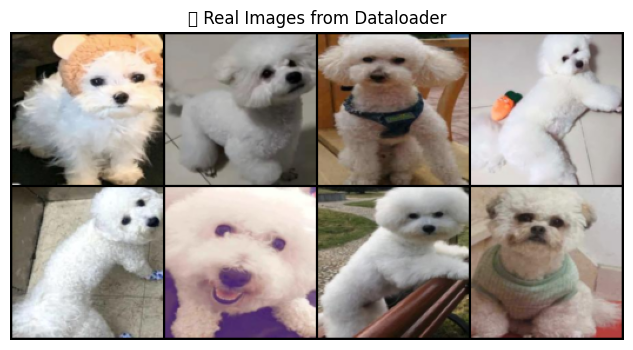

Labels: [0, 0, 1, 0, 0, 1, 0, 0]


In [10]:
# ÌôîÍ∏¥

# ------------------------------
# 1. ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
# ------------------------------
batch_size = 64
# z_dim = 100              # ‚úÖ ÎÖºÎ¨∏Ïóê ÎßûÏ∂∞ Ï∂ïÏÜå
z_dim = 128
c_dim = 2
lr = 2e-4
num_epochs = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torch.utils.data import DataLoader

# ------------------------------
# 2. Transform
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

# ------------------------------
# 3. Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
# ------------------------------
dataset = AFACDataset("AFAC/AFAC.txt", "AFAC/preprocessed", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Î∞∞Ïπò ÌïòÎÇò Î∞õÏïÑÏò§Í∏∞
real_imgs, real_labels = next(iter(dataloader))

# Ï†ïÍ∑úÌôî Ìï¥Ï†ú: [-1, 1] ‚Üí [0, 1]
def denormalize(t):
    return t * 0.5 + 0.5

# Ïù¥ÎØ∏ÏßÄ Í∑∏Î¶¨ÎìúÎ°ú ÎßåÎì§Í≥† ÏãúÍ∞ÅÌôî
grid = vutils.make_grid(denormalize(real_imgs[:8]), nrow=4)
plt.figure(figsize=(8, 4))
plt.imshow(grid.permute(1, 2, 0))  # (C, H, W) ‚Üí (H, W, C)
plt.title("üí° Real Images from Dataloader")
plt.axis('off')
plt.show()

# ÎùºÎ≤®ÎèÑ Ìï®Íªò Ï∂úÎ†•
print("Labels:", real_labels[:8].tolist())

In [8]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import save_image  # Îß® ÏúÑÏóê Ï∂îÍ∞Ä
from torch.optim.lr_scheduler import StepLR

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('ConvTranspose') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# ------------------------------
# 1. ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
# ------------------------------
batch_size = 64
# z_dim = 100              # ‚úÖ ÎÖºÎ¨∏Ïóê ÎßûÏ∂∞ Ï∂ïÏÜå
z_dim = 128
c_dim = 2
lr = 2e-4
num_epochs = 300

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ------------------------------
# 2. Transform
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

# ------------------------------
# 3. Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
# ------------------------------
dataset = AFACDataset("AFAC/AFAC.txt", "AFAC/preprocessed", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# ------------------------------
# 4. Î™®Îç∏ Ï†ïÏùò
# ------------------------------
# G = Generator(z_dim=z_dim, c_dim=c_dim).to(device)
G = InjectionGenerator(z_dim=z_dim, c_dim=c_dim).to(device)
# D = Discriminator(c_dim=c_dim).to(device)
D = ProjectionDiscriminator(c_dim=c_dim).to(device)


# ‚úÖ Weight Ï¥àÍ∏∞Ìôî (DCGAN Î∞©Ïãù)
G.apply(weights_init)
D.apply(weights_init)

# ------------------------------
# 5. ÏÜêÏã§ Î∞è ÏµúÏ†ÅÌôî
# ------------------------------
# bce_loss = nn.BCEWithLogitsLoss()   # ‚úÖ Sigmoid ÏóÜÏù¥ ÏÇ¨Ïö©
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
scheduler_G = StepLR(optimizer_G, step_size=50, gamma=0.5)
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# ------------------------------
# 6. Ïú†Ìã∏ Ìï®Ïàò
# ------------------------------        
# def generate_labels(size, value):
#     return torch.full((size, 1), value, dtype=torch.float, device=device)

def denormalize(t):
    return t * 0.5 + 0.5

def show_samples(generated_imgs, labels, title):
    grid = utils.make_grid(denormalize(generated_imgs[:8].cpu()), nrow=4)
    plt.figure(figsize=(8, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

# ------------------------------
# 7. ÌïôÏäµ Î£®ÌîÑ
# ------------------------------
best_g_loss = float('inf')
z_fixed = torch.randn(20, z_dim, device=device)  # ‚úÖ Í≥†Ï†ï latent Î≤°ÌÑ∞ # ÏàòÏ†ï

for epoch in range(num_epochs):
    G.train()
    D.train()
    epoch_start = time.time()
    loop = tqdm(dataloader, desc=f"[Epoch {epoch + 1}/{num_epochs}]", leave=False)

    for real_imgs, real_labels in loop:
        real_imgs = real_imgs.to(device)
        real_labels = real_labels.to(device)
        batch_size = real_imgs.size(0)

        z = torch.randn(batch_size, z_dim, device=device)

        # ‚ñí Train D ‚ñí
        D.zero_grad()
        
        # (1) Real Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌïú loss
        real_out = D(real_imgs, real_labels)  # [B, 1]
        loss_D_real = torch.mean(F.relu(1.0 - real_out))  # hinge loss for real
        
        # (2) Fake Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ±
        fake_labels = torch.randint(0, c_dim, (batch_size,), device=device)
        fake_cond = F.one_hot(fake_labels, num_classes=c_dim).float()
        fake_imgs = G(z, fake_cond)
        
        # (3) Fake Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌïú loss
        fake_out = D(fake_imgs.detach(), fake_labels)
        loss_D_fake = torch.mean(F.relu(1.0 + fake_out))  # hinge loss for fake
        
        d_loss = loss_D_real + loss_D_fake
        d_loss.backward()
        optimizer_D.step()
        
        # ‚ñí Train G ‚ñí
        G.zero_grad()
        fake_imgs = G(z, fake_cond)
        fake_out = D(fake_imgs, fake_labels)
        
        g_loss = -torch.mean(fake_out)  # generator tries to increase D output
        
        g_loss.backward()
        optimizer_G.step()

        loop.set_postfix(d_loss=d_loss.item(), g_loss=g_loss.item())

    scheduler_G.step()  # üî∫ epoch ÎÅùÎÇòÍ≥† Ìïú Î≤à Ìò∏Ï∂ú # Ïó¨Í∏∞ Ï∂îÍ∞Ä!
    elapsed = time.time() - epoch_start
    print(f"‚úÖ Epoch {epoch + 1:03d} ÏôÑÎ£å | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f} | ÏÜåÏöîÏãúÍ∞Ñ: {elapsed / 60:.2f}Î∂Ñ")

    # ------------------------------
    # 8. Îß§ N epochÎßàÎã§ Ï†ÄÏû•
    # ------------------------------
    save_every = 10  # üî∏10 epochÎßàÎã§ Ï†ÄÏû•
    version = "injected"  # üî∏ "injected"Î°ú Î∞îÍøîÏÑú ÏÇ¨Ïö© Í∞ÄÎä•
    
    ckpt_dir = os.path.join("checkpoints", version)
    sample_dir = os.path.join("samples", version)
    
    os.makedirs(ckpt_dir, exist_ok=True)
    os.makedirs(sample_dir, exist_ok=True)
    
    if (epoch + 1) % save_every == 0:
        # G weight Ï†ÄÏû•
        ckpt_path = os.path.join(ckpt_dir, f"G_epoch_{epoch+1:03d}.pth")
        checkpoint = {
            'epoch': epoch + 1,
            'G_state_dict': G.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'g_loss': g_loss.item(),
            'z_sample': z[:20].detach().cpu(),
            'c_sample': fake_labels[:20].detach().cpu()  # Ï°∞Í±¥ÏùÑ fake_labelsÎ°ú Ï†ÄÏû•
        }
        torch.save(checkpoint, ckpt_path)
        
        # Ïù¥ÎØ∏ÏßÄ Ï†ÄÏû•
        img_path = os.path.join(sample_dir, f"sample_epoch_{epoch+1:03d}.png")
        
        with torch.no_grad():
            z_fixed = z_fixed  # ÎèôÏùºÌïú latent vector # ÏàòÏ†ï
    
            c_young = torch.zeros(20, dtype=torch.long, device=device)
            c_senior = torch.ones(20, dtype=torch.long, device=device)
    
            cond_young = F.one_hot(c_young, num_classes=c_dim).float()
            cond_senior = F.one_hot(c_senior, num_classes=c_dim).float()
    
            gen_young = G(z_fixed, cond_young)   # [20, 3, 128, 128]
            gen_senior = G(z_fixed, cond_senior) # [20, 3, 128, 128]
    
            interleaved = torch.stack([gen_young, gen_senior], dim=1)  # [20, 2, 3, 128, 128]
            sample_imgs = interleaved.flatten(0, 1)                    # [40, 3, 128, 128]
            save_image(denormalize(sample_imgs), img_path, nrow=10)

‚úÖ Ï¥ù Î°úÎìúÎêú ÏÉòÌîå Ïàò: 16920
‚ö†Ô∏è ÎàÑÎùΩÎêú Ïù¥ÎØ∏ÏßÄ ÌååÏùº Ïàò: 1
ÏòàÏãú ÎàÑÎùΩ ÌååÏùºÎ™Ö: ['O1CN01DYF38A20tSMfFRYma_!!6000000006907-0-antinsbiocamera.jpeg']


‚úÖ Epoch 001 ÏôÑÎ£å | D_loss: 1.8247 | G_loss: -0.1756 | ÏÜåÏöîÏãúÍ∞Ñ: 0.49Î∂Ñ


‚úÖ Epoch 002 ÏôÑÎ£å | D_loss: 1.6624 | G_loss: 0.9263 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 003 ÏôÑÎ£å | D_loss: 1.7082 | G_loss: 0.4536 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 004 ÏôÑÎ£å | D_loss: 1.3569 | G_loss: 0.6434 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 005 ÏôÑÎ£å | D_loss: 0.7365 | G_loss: 0.9734 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 006 ÏôÑÎ£å | D_loss: 1.1047 | G_loss: 0.9795 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 007 ÏôÑÎ£å | D_loss: 1.6299 | G_loss: 0.8843 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 008 ÏôÑÎ£å | D_loss: 0.9980 | G_loss: 0.8678 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 009 ÏôÑÎ£å | D_loss: 0.7235 | G_loss: 0.9188 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 010 ÏôÑÎ£å | D_loss: 1.1304 | G_loss: 1.0056 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 011 ÏôÑÎ£å | D_loss: 1.4498 | G_loss: 0.9908 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 012 ÏôÑÎ£å | D_loss: 1.3206 | G_loss: 0.6136 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 013 ÏôÑÎ£å | D_loss: 1.3981 | G_loss: 0.9678 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 014 ÏôÑÎ£å | D_loss: 1.0859 | G_loss: 0.8111 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 015 ÏôÑÎ£å | D_loss: 1.1944 | G_loss: 1.1366 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 016 ÏôÑÎ£å | D_loss: 1.6287 | G_loss: 0.9103 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 017 ÏôÑÎ£å | D_loss: 1.1434 | G_loss: 0.6711 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 018 ÏôÑÎ£å | D_loss: 1.5198 | G_loss: 0.9857 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 019 ÏôÑÎ£å | D_loss: 1.2826 | G_loss: 1.0266 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 020 ÏôÑÎ£å | D_loss: 0.6851 | G_loss: 1.1239 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 021 ÏôÑÎ£å | D_loss: 1.0320 | G_loss: 0.9351 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 022 ÏôÑÎ£å | D_loss: 1.1936 | G_loss: 1.1830 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 023 ÏôÑÎ£å | D_loss: 1.5172 | G_loss: 0.9447 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 024 ÏôÑÎ£å | D_loss: 1.0331 | G_loss: 1.1064 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 025 ÏôÑÎ£å | D_loss: 1.6156 | G_loss: 0.6276 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 026 ÏôÑÎ£å | D_loss: 1.2739 | G_loss: 0.8706 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 027 ÏôÑÎ£å | D_loss: 1.3805 | G_loss: 1.0549 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 028 ÏôÑÎ£å | D_loss: 0.9384 | G_loss: 1.3324 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 029 ÏôÑÎ£å | D_loss: 1.2532 | G_loss: 1.1374 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 030 ÏôÑÎ£å | D_loss: 1.7200 | G_loss: 1.0687 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 031 ÏôÑÎ£å | D_loss: 1.3653 | G_loss: 1.1949 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 032 ÏôÑÎ£å | D_loss: 1.4875 | G_loss: 1.0655 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 033 ÏôÑÎ£å | D_loss: 1.2527 | G_loss: 1.0831 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 034 ÏôÑÎ£å | D_loss: 1.2939 | G_loss: 0.8216 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 035 ÏôÑÎ£å | D_loss: 1.4565 | G_loss: 0.8259 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 036 ÏôÑÎ£å | D_loss: 1.3980 | G_loss: 0.6158 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 037 ÏôÑÎ£å | D_loss: 1.1574 | G_loss: 0.9588 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 038 ÏôÑÎ£å | D_loss: 1.0207 | G_loss: 0.9617 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 039 ÏôÑÎ£å | D_loss: 1.2909 | G_loss: 1.2187 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 040 ÏôÑÎ£å | D_loss: 1.1096 | G_loss: 0.9777 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 041 ÏôÑÎ£å | D_loss: 1.6627 | G_loss: 1.3602 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 042 ÏôÑÎ£å | D_loss: 1.3315 | G_loss: 0.9174 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 043 ÏôÑÎ£å | D_loss: 1.4396 | G_loss: 0.8505 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 044 ÏôÑÎ£å | D_loss: 1.4245 | G_loss: 0.7789 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 045 ÏôÑÎ£å | D_loss: 1.4273 | G_loss: 0.7530 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 046 ÏôÑÎ£å | D_loss: 1.4492 | G_loss: 0.5358 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 047 ÏôÑÎ£å | D_loss: 1.1707 | G_loss: 1.3795 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 048 ÏôÑÎ£å | D_loss: 1.3779 | G_loss: 1.2665 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 049 ÏôÑÎ£å | D_loss: 0.9233 | G_loss: 0.8457 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 050 ÏôÑÎ£å | D_loss: 1.0849 | G_loss: 1.1637 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 051 ÏôÑÎ£å | D_loss: 1.0528 | G_loss: 0.8077 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 052 ÏôÑÎ£å | D_loss: 1.1342 | G_loss: 0.6353 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 053 ÏôÑÎ£å | D_loss: 1.3464 | G_loss: 0.9943 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 054 ÏôÑÎ£å | D_loss: 1.2755 | G_loss: 1.2969 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 055 ÏôÑÎ£å | D_loss: 1.5888 | G_loss: 1.6430 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 056 ÏôÑÎ£å | D_loss: 0.8847 | G_loss: 1.1810 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 057 ÏôÑÎ£å | D_loss: 1.1280 | G_loss: 0.9631 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 058 ÏôÑÎ£å | D_loss: 0.9121 | G_loss: 1.4745 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 059 ÏôÑÎ£å | D_loss: 1.0555 | G_loss: 0.5209 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 060 ÏôÑÎ£å | D_loss: 1.1867 | G_loss: 1.1273 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 061 ÏôÑÎ£å | D_loss: 0.9870 | G_loss: 2.0762 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 062 ÏôÑÎ£å | D_loss: 0.9447 | G_loss: 1.5123 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 063 ÏôÑÎ£å | D_loss: 0.6875 | G_loss: 1.0739 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 064 ÏôÑÎ£å | D_loss: 0.9265 | G_loss: 2.1281 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 065 ÏôÑÎ£å | D_loss: 1.0543 | G_loss: 1.1993 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 066 ÏôÑÎ£å | D_loss: 0.9701 | G_loss: 1.1223 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 067 ÏôÑÎ£å | D_loss: 0.7899 | G_loss: 1.3205 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 068 ÏôÑÎ£å | D_loss: 0.9949 | G_loss: 1.1051 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 069 ÏôÑÎ£å | D_loss: 0.9534 | G_loss: 1.5092 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 070 ÏôÑÎ£å | D_loss: 0.9613 | G_loss: 0.9457 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 071 ÏôÑÎ£å | D_loss: 1.0906 | G_loss: 1.1906 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 072 ÏôÑÎ£å | D_loss: 1.0013 | G_loss: 1.4129 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 073 ÏôÑÎ£å | D_loss: 1.0498 | G_loss: 0.5773 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 074 ÏôÑÎ£å | D_loss: 0.8733 | G_loss: 0.9305 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 075 ÏôÑÎ£å | D_loss: 0.9249 | G_loss: 1.8257 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 076 ÏôÑÎ£å | D_loss: 0.6362 | G_loss: 1.9214 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 077 ÏôÑÎ£å | D_loss: 1.1227 | G_loss: 1.3993 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 078 ÏôÑÎ£å | D_loss: 0.8605 | G_loss: 1.1685 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 079 ÏôÑÎ£å | D_loss: 0.6832 | G_loss: 1.0332 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 080 ÏôÑÎ£å | D_loss: 1.0194 | G_loss: -0.0327 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 081 ÏôÑÎ£å | D_loss: 0.5932 | G_loss: 1.3140 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 082 ÏôÑÎ£å | D_loss: 0.8286 | G_loss: 1.5847 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 083 ÏôÑÎ£å | D_loss: 0.7318 | G_loss: 0.8045 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 084 ÏôÑÎ£å | D_loss: 0.5290 | G_loss: 1.9484 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 085 ÏôÑÎ£å | D_loss: 0.6436 | G_loss: 1.0552 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 086 ÏôÑÎ£å | D_loss: 1.1523 | G_loss: 1.7783 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 087 ÏôÑÎ£å | D_loss: 0.9847 | G_loss: 1.5601 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 088 ÏôÑÎ£å | D_loss: 0.8336 | G_loss: 0.8517 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 089 ÏôÑÎ£å | D_loss: 0.8312 | G_loss: 1.2278 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 090 ÏôÑÎ£å | D_loss: 0.6262 | G_loss: 1.6679 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 091 ÏôÑÎ£å | D_loss: 0.5441 | G_loss: 1.8696 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 092 ÏôÑÎ£å | D_loss: 0.5395 | G_loss: 2.2459 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 093 ÏôÑÎ£å | D_loss: 1.0346 | G_loss: 1.1975 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 094 ÏôÑÎ£å | D_loss: 0.9003 | G_loss: 1.7806 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 095 ÏôÑÎ£å | D_loss: 0.9120 | G_loss: 1.8932 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 096 ÏôÑÎ£å | D_loss: 0.8834 | G_loss: 2.7414 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 097 ÏôÑÎ£å | D_loss: 0.6476 | G_loss: 1.3924 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 098 ÏôÑÎ£å | D_loss: 0.6856 | G_loss: 1.1268 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 099 ÏôÑÎ£å | D_loss: 0.8001 | G_loss: 1.6874 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 100 ÏôÑÎ£å | D_loss: 0.5348 | G_loss: 1.6459 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 101 ÏôÑÎ£å | D_loss: 0.4436 | G_loss: 1.8362 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 102 ÏôÑÎ£å | D_loss: 0.4015 | G_loss: 1.7819 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 103 ÏôÑÎ£å | D_loss: 0.3856 | G_loss: 1.9333 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 104 ÏôÑÎ£å | D_loss: 0.7104 | G_loss: 2.0000 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 105 ÏôÑÎ£å | D_loss: 0.8900 | G_loss: 1.1508 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 106 ÏôÑÎ£å | D_loss: 0.5229 | G_loss: 2.0642 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 107 ÏôÑÎ£å | D_loss: 0.5069 | G_loss: 0.9779 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 108 ÏôÑÎ£å | D_loss: 0.8850 | G_loss: 1.4227 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 109 ÏôÑÎ£å | D_loss: 0.3727 | G_loss: 1.5954 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 110 ÏôÑÎ£å | D_loss: 0.4008 | G_loss: 0.7697 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 111 ÏôÑÎ£å | D_loss: 0.5676 | G_loss: 0.4549 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 112 ÏôÑÎ£å | D_loss: 0.3062 | G_loss: 1.4271 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 113 ÏôÑÎ£å | D_loss: 0.2531 | G_loss: 1.7971 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 114 ÏôÑÎ£å | D_loss: 0.3245 | G_loss: 2.0952 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 115 ÏôÑÎ£å | D_loss: 0.5376 | G_loss: 1.1772 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 116 ÏôÑÎ£å | D_loss: 0.3661 | G_loss: 2.0162 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 117 ÏôÑÎ£å | D_loss: 0.5684 | G_loss: 2.5926 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 118 ÏôÑÎ£å | D_loss: 0.3083 | G_loss: 1.7366 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 119 ÏôÑÎ£å | D_loss: 0.5843 | G_loss: 2.6032 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 120 ÏôÑÎ£å | D_loss: 0.5500 | G_loss: 1.7046 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 121 ÏôÑÎ£å | D_loss: 0.4121 | G_loss: 2.5862 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 122 ÏôÑÎ£å | D_loss: 0.1617 | G_loss: 1.9560 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 123 ÏôÑÎ£å | D_loss: 0.3596 | G_loss: 2.5479 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 124 ÏôÑÎ£å | D_loss: 0.3900 | G_loss: 1.7813 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 125 ÏôÑÎ£å | D_loss: 0.5952 | G_loss: 1.1083 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 126 ÏôÑÎ£å | D_loss: 0.5945 | G_loss: 2.2356 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 127 ÏôÑÎ£å | D_loss: 0.1900 | G_loss: 1.6152 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 128 ÏôÑÎ£å | D_loss: 0.5621 | G_loss: 2.2338 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 129 ÏôÑÎ£å | D_loss: 0.1995 | G_loss: 2.0148 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 130 ÏôÑÎ£å | D_loss: 0.2600 | G_loss: 1.3748 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 131 ÏôÑÎ£å | D_loss: 0.1998 | G_loss: 2.0280 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 132 ÏôÑÎ£å | D_loss: 0.3309 | G_loss: 2.4642 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 133 ÏôÑÎ£å | D_loss: 0.5075 | G_loss: 1.2077 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 134 ÏôÑÎ£å | D_loss: 0.2653 | G_loss: 2.1557 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 135 ÏôÑÎ£å | D_loss: 0.3044 | G_loss: 2.5100 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 136 ÏôÑÎ£å | D_loss: 0.2359 | G_loss: 1.9511 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 137 ÏôÑÎ£å | D_loss: 0.1300 | G_loss: 2.0148 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 138 ÏôÑÎ£å | D_loss: 0.2039 | G_loss: 2.7439 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 139 ÏôÑÎ£å | D_loss: 0.3558 | G_loss: 1.3173 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 140 ÏôÑÎ£å | D_loss: 0.2911 | G_loss: 2.2178 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 141 ÏôÑÎ£å | D_loss: 0.3224 | G_loss: 2.3096 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 142 ÏôÑÎ£å | D_loss: 0.0885 | G_loss: 2.3634 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 143 ÏôÑÎ£å | D_loss: 0.3294 | G_loss: 1.6360 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 144 ÏôÑÎ£å | D_loss: 0.4701 | G_loss: 0.7866 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 145 ÏôÑÎ£å | D_loss: 0.2946 | G_loss: 2.0995 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 146 ÏôÑÎ£å | D_loss: 0.1804 | G_loss: 2.3155 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 147 ÏôÑÎ£å | D_loss: 0.1786 | G_loss: 2.3558 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 148 ÏôÑÎ£å | D_loss: 0.3720 | G_loss: 1.5991 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 149 ÏôÑÎ£å | D_loss: 0.2677 | G_loss: 1.8417 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 150 ÏôÑÎ£å | D_loss: 0.1350 | G_loss: 1.8511 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 151 ÏôÑÎ£å | D_loss: 0.2224 | G_loss: 2.1896 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 152 ÏôÑÎ£å | D_loss: 0.2143 | G_loss: 2.6217 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 153 ÏôÑÎ£å | D_loss: 0.2819 | G_loss: 2.8333 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 154 ÏôÑÎ£å | D_loss: 0.2745 | G_loss: 2.6710 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 155 ÏôÑÎ£å | D_loss: 0.1247 | G_loss: 1.4617 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 156 ÏôÑÎ£å | D_loss: 0.1242 | G_loss: 2.0578 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 157 ÏôÑÎ£å | D_loss: 0.0792 | G_loss: 1.6587 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 158 ÏôÑÎ£å | D_loss: 0.2076 | G_loss: 2.0320 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 159 ÏôÑÎ£å | D_loss: 0.2482 | G_loss: 2.1033 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 160 ÏôÑÎ£å | D_loss: 0.3034 | G_loss: 3.0000 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 161 ÏôÑÎ£å | D_loss: 0.2330 | G_loss: 2.4406 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 162 ÏôÑÎ£å | D_loss: 0.1709 | G_loss: 1.6907 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 163 ÏôÑÎ£å | D_loss: 0.0742 | G_loss: 2.3594 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 164 ÏôÑÎ£å | D_loss: 0.1841 | G_loss: 2.4244 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 165 ÏôÑÎ£å | D_loss: 0.2947 | G_loss: 2.0873 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 166 ÏôÑÎ£å | D_loss: 0.1953 | G_loss: 2.1668 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 167 ÏôÑÎ£å | D_loss: 0.3429 | G_loss: 0.8039 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 168 ÏôÑÎ£å | D_loss: 0.1066 | G_loss: 1.8371 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 169 ÏôÑÎ£å | D_loss: 0.0980 | G_loss: 2.4746 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 170 ÏôÑÎ£å | D_loss: 0.1922 | G_loss: 1.9513 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 171 ÏôÑÎ£å | D_loss: 0.2910 | G_loss: 2.4466 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 172 ÏôÑÎ£å | D_loss: 0.3069 | G_loss: 1.7833 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 173 ÏôÑÎ£å | D_loss: 0.1033 | G_loss: 2.2898 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 174 ÏôÑÎ£å | D_loss: 0.2092 | G_loss: 1.2772 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 175 ÏôÑÎ£å | D_loss: 0.0872 | G_loss: 2.2668 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 176 ÏôÑÎ£å | D_loss: 0.1713 | G_loss: 2.6803 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 177 ÏôÑÎ£å | D_loss: 0.2631 | G_loss: 0.9043 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 178 ÏôÑÎ£å | D_loss: 0.1360 | G_loss: 1.5288 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 179 ÏôÑÎ£å | D_loss: 0.0950 | G_loss: 2.1768 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 180 ÏôÑÎ£å | D_loss: 0.0230 | G_loss: 2.2985 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 181 ÏôÑÎ£å | D_loss: 0.1230 | G_loss: 1.4420 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 182 ÏôÑÎ£å | D_loss: 0.1781 | G_loss: 1.5464 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 183 ÏôÑÎ£å | D_loss: 0.1168 | G_loss: 2.2640 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 184 ÏôÑÎ£å | D_loss: 0.1574 | G_loss: 1.5273 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 185 ÏôÑÎ£å | D_loss: 0.0242 | G_loss: 1.5847 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 186 ÏôÑÎ£å | D_loss: 0.2816 | G_loss: 3.0116 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 187 ÏôÑÎ£å | D_loss: 0.1397 | G_loss: 2.3210 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 188 ÏôÑÎ£å | D_loss: 0.1274 | G_loss: 2.5694 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 189 ÏôÑÎ£å | D_loss: 0.1317 | G_loss: 1.6302 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 190 ÏôÑÎ£å | D_loss: 0.1258 | G_loss: 1.9078 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 191 ÏôÑÎ£å | D_loss: 0.0760 | G_loss: 2.3930 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 192 ÏôÑÎ£å | D_loss: 0.0849 | G_loss: 2.0811 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 193 ÏôÑÎ£å | D_loss: 0.0975 | G_loss: 1.5291 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 194 ÏôÑÎ£å | D_loss: 0.1489 | G_loss: 2.4507 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 195 ÏôÑÎ£å | D_loss: 0.1623 | G_loss: 1.8355 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 196 ÏôÑÎ£å | D_loss: 0.0813 | G_loss: 2.1829 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 197 ÏôÑÎ£å | D_loss: 0.2415 | G_loss: 1.1949 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 198 ÏôÑÎ£å | D_loss: 0.1056 | G_loss: 1.6668 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 199 ÏôÑÎ£å | D_loss: 0.1734 | G_loss: 2.7927 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 200 ÏôÑÎ£å | D_loss: 0.2121 | G_loss: 1.9167 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 201 ÏôÑÎ£å | D_loss: 0.0131 | G_loss: 2.1729 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 202 ÏôÑÎ£å | D_loss: 0.0794 | G_loss: 2.4574 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 203 ÏôÑÎ£å | D_loss: 0.0946 | G_loss: 1.9836 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 204 ÏôÑÎ£å | D_loss: 0.0736 | G_loss: 2.1675 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 205 ÏôÑÎ£å | D_loss: 0.0617 | G_loss: 1.9698 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 206 ÏôÑÎ£å | D_loss: 0.0535 | G_loss: 1.4341 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 207 ÏôÑÎ£å | D_loss: 0.0347 | G_loss: 2.2685 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 208 ÏôÑÎ£å | D_loss: 0.0895 | G_loss: 1.9729 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 209 ÏôÑÎ£å | D_loss: 0.1068 | G_loss: 2.4839 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 210 ÏôÑÎ£å | D_loss: 0.0558 | G_loss: 1.9396 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 211 ÏôÑÎ£å | D_loss: 0.0710 | G_loss: 2.3320 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 212 ÏôÑÎ£å | D_loss: 0.0678 | G_loss: 2.5795 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 213 ÏôÑÎ£å | D_loss: 0.1284 | G_loss: 2.4493 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 214 ÏôÑÎ£å | D_loss: 0.2693 | G_loss: 2.6301 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 215 ÏôÑÎ£å | D_loss: 0.1414 | G_loss: 2.0778 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 216 ÏôÑÎ£å | D_loss: 0.0672 | G_loss: 2.4499 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 217 ÏôÑÎ£å | D_loss: 0.3052 | G_loss: 2.1781 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 218 ÏôÑÎ£å | D_loss: 0.1361 | G_loss: 1.7340 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 219 ÏôÑÎ£å | D_loss: 0.0478 | G_loss: 2.9058 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 220 ÏôÑÎ£å | D_loss: 0.1353 | G_loss: 2.7560 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 221 ÏôÑÎ£å | D_loss: 0.0151 | G_loss: 1.5067 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 222 ÏôÑÎ£å | D_loss: 0.0958 | G_loss: 2.4603 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 223 ÏôÑÎ£å | D_loss: 0.0775 | G_loss: 1.8251 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 224 ÏôÑÎ£å | D_loss: 0.0219 | G_loss: 1.9846 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 225 ÏôÑÎ£å | D_loss: 0.0902 | G_loss: 2.5160 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 226 ÏôÑÎ£å | D_loss: 0.0519 | G_loss: 2.0634 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 227 ÏôÑÎ£å | D_loss: 0.1185 | G_loss: 2.0897 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 228 ÏôÑÎ£å | D_loss: 0.1443 | G_loss: 1.9690 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 229 ÏôÑÎ£å | D_loss: 0.0239 | G_loss: 2.5923 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 230 ÏôÑÎ£å | D_loss: 0.0280 | G_loss: 1.9842 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 231 ÏôÑÎ£å | D_loss: 0.1176 | G_loss: 2.0402 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 232 ÏôÑÎ£å | D_loss: 0.0556 | G_loss: 2.5122 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 233 ÏôÑÎ£å | D_loss: 0.0544 | G_loss: 2.2171 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 234 ÏôÑÎ£å | D_loss: 0.1016 | G_loss: 2.3157 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 235 ÏôÑÎ£å | D_loss: 0.1409 | G_loss: 1.9893 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 236 ÏôÑÎ£å | D_loss: 0.0372 | G_loss: 2.5183 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 237 ÏôÑÎ£å | D_loss: 0.0289 | G_loss: 2.3066 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 238 ÏôÑÎ£å | D_loss: 0.1078 | G_loss: 1.8366 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 239 ÏôÑÎ£å | D_loss: 0.0581 | G_loss: 2.4178 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 240 ÏôÑÎ£å | D_loss: 0.0443 | G_loss: 1.8831 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 241 ÏôÑÎ£å | D_loss: 0.0423 | G_loss: 2.1933 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 242 ÏôÑÎ£å | D_loss: 0.0751 | G_loss: 1.5881 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 243 ÏôÑÎ£å | D_loss: 0.0584 | G_loss: 1.5315 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 244 ÏôÑÎ£å | D_loss: 0.0309 | G_loss: 2.1743 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 245 ÏôÑÎ£å | D_loss: 0.0997 | G_loss: 1.6862 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 246 ÏôÑÎ£å | D_loss: 0.0008 | G_loss: 2.1095 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 247 ÏôÑÎ£å | D_loss: 0.0384 | G_loss: 2.7816 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 248 ÏôÑÎ£å | D_loss: 0.0575 | G_loss: 2.3457 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 249 ÏôÑÎ£å | D_loss: 0.0577 | G_loss: 2.6537 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 250 ÏôÑÎ£å | D_loss: 0.0204 | G_loss: 2.0088 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 251 ÏôÑÎ£å | D_loss: 0.0863 | G_loss: 1.3439 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 252 ÏôÑÎ£å | D_loss: 0.1167 | G_loss: 2.0838 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 253 ÏôÑÎ£å | D_loss: 0.1308 | G_loss: 2.1408 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 254 ÏôÑÎ£å | D_loss: 0.0204 | G_loss: 2.0899 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 255 ÏôÑÎ£å | D_loss: 0.0914 | G_loss: 1.9897 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 256 ÏôÑÎ£å | D_loss: 0.0756 | G_loss: 3.0881 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 257 ÏôÑÎ£å | D_loss: 0.0444 | G_loss: 1.7451 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 258 ÏôÑÎ£å | D_loss: 0.0613 | G_loss: 2.7230 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 259 ÏôÑÎ£å | D_loss: 0.0348 | G_loss: 2.1312 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 260 ÏôÑÎ£å | D_loss: 0.1074 | G_loss: 3.0859 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 261 ÏôÑÎ£å | D_loss: 0.0153 | G_loss: 2.5342 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 262 ÏôÑÎ£å | D_loss: 0.0484 | G_loss: 2.7970 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 263 ÏôÑÎ£å | D_loss: 0.1033 | G_loss: 1.9719 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 264 ÏôÑÎ£å | D_loss: 0.0898 | G_loss: 2.1801 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 265 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 2.1735 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 266 ÏôÑÎ£å | D_loss: 0.2096 | G_loss: 2.8361 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 267 ÏôÑÎ£å | D_loss: 0.0281 | G_loss: 2.9502 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 268 ÏôÑÎ£å | D_loss: 0.0209 | G_loss: 2.0849 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 269 ÏôÑÎ£å | D_loss: 0.0896 | G_loss: 2.3821 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 270 ÏôÑÎ£å | D_loss: 0.0542 | G_loss: 2.2482 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 271 ÏôÑÎ£å | D_loss: 0.0483 | G_loss: 2.2476 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 272 ÏôÑÎ£å | D_loss: 0.0522 | G_loss: 2.4141 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 273 ÏôÑÎ£å | D_loss: 0.0660 | G_loss: 2.2428 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 274 ÏôÑÎ£å | D_loss: 0.0462 | G_loss: 2.8965 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 275 ÏôÑÎ£å | D_loss: 0.1167 | G_loss: 2.8628 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 276 ÏôÑÎ£å | D_loss: 0.0857 | G_loss: 2.6339 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 277 ÏôÑÎ£å | D_loss: 0.1639 | G_loss: 1.7428 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 278 ÏôÑÎ£å | D_loss: 0.0402 | G_loss: 1.9369 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 279 ÏôÑÎ£å | D_loss: 0.0072 | G_loss: 2.1776 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 280 ÏôÑÎ£å | D_loss: 0.0346 | G_loss: 1.9355 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 281 ÏôÑÎ£å | D_loss: 0.0747 | G_loss: 1.9661 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 282 ÏôÑÎ£å | D_loss: 0.0454 | G_loss: 2.4454 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 283 ÏôÑÎ£å | D_loss: 0.0700 | G_loss: 2.0751 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 284 ÏôÑÎ£å | D_loss: 0.0237 | G_loss: 1.8704 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 285 ÏôÑÎ£å | D_loss: 0.0197 | G_loss: 1.9768 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 286 ÏôÑÎ£å | D_loss: 0.0354 | G_loss: 2.4697 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 287 ÏôÑÎ£å | D_loss: 0.0322 | G_loss: 2.8582 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 288 ÏôÑÎ£å | D_loss: 0.1366 | G_loss: 1.7191 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 289 ÏôÑÎ£å | D_loss: 0.0504 | G_loss: 2.3164 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 290 ÏôÑÎ£å | D_loss: 0.0289 | G_loss: 2.4869 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 291 ÏôÑÎ£å | D_loss: 0.0532 | G_loss: 2.0892 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 292 ÏôÑÎ£å | D_loss: 0.0449 | G_loss: 2.6852 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 293 ÏôÑÎ£å | D_loss: 0.0394 | G_loss: 2.6659 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 294 ÏôÑÎ£å | D_loss: 0.0168 | G_loss: 2.3564 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 295 ÏôÑÎ£å | D_loss: 0.0888 | G_loss: 2.4503 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 296 ÏôÑÎ£å | D_loss: 0.0373 | G_loss: 2.0817 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 297 ÏôÑÎ£å | D_loss: 0.0173 | G_loss: 2.6011 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 298 ÏôÑÎ£å | D_loss: 0.0232 | G_loss: 2.4726 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


‚úÖ Epoch 299 ÏôÑÎ£å | D_loss: 0.0117 | G_loss: 2.3483 | ÏÜåÏöîÏãúÍ∞Ñ: 0.47Î∂Ñ


‚úÖ Epoch 300 ÏôÑÎ£å | D_loss: 0.0722 | G_loss: 2.6211 | ÏÜåÏöîÏãúÍ∞Ñ: 0.48Î∂Ñ


In [25]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

# ------------------------------
# 1. ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
# ------------------------------
batch_size = 64
z_dim = 128
c_dim = 2
lr = 2e-4
num_epochs = 300
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ------------------------------
# 2. Transform
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

# ------------------------------
# 3. Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
# ------------------------------
dataset = AFACDataset("AFAC/AFAC.txt", "AFAC/preprocessed", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# ------------------------------
# 4. Î™®Îç∏ Ï†ïÏùò (‚úÖ ÏÉàÎ°úÏö¥ Î≤ÑÏ†Ñ ÏÇ¨Ïö©)
# ------------------------------
G = ConcatGenerator(z_dim=z_dim, c_dim=c_dim, c_emb_dim=16).to(device)
D = ConcatDiscriminator(c_dim=c_dim, embed_dim=16).to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('ConvTranspose') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G.apply(weights_init)
D.apply(weights_init)

# ------------------------------
# 5. ÏÜêÏã§ Î∞è ÏµúÏ†ÅÌôî
# ------------------------------
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
scheduler_G = StepLR(optimizer_G, step_size=50, gamma=0.5)
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# ------------------------------
# 6. Ïú†Ìã∏ Ìï®Ïàò
# ------------------------------
def denormalize(t):
    return t * 0.5 + 0.5

# ------------------------------
# 7. ÌïôÏäµ Î£®ÌîÑ
# ------------------------------
best_g_loss = float('inf')
z_fixed = torch.randn(20, z_dim, device=device)

for epoch in range(num_epochs):
    G.train()
    D.train()
    epoch_start = time.time()
    loop = tqdm(dataloader, desc=f"[Epoch {epoch + 1}/{num_epochs}]", leave=False)

    for real_imgs, real_labels in loop:
        real_imgs = real_imgs.to(device)
        real_labels = real_labels.to(device)
        batch_size = real_imgs.size(0)

        z = torch.randn(batch_size, z_dim, device=device)

        # ‚ñí Train D ‚ñí
        D.zero_grad()
        real_out = D(real_imgs, F.one_hot(real_labels, num_classes=c_dim).float())
        loss_D_real = torch.mean(F.relu(1.0 - real_out))

        fake_labels = torch.randint(0, c_dim, (batch_size,), device=device)
        fake_cond = F.one_hot(fake_labels, num_classes=c_dim).float()
        fake_imgs = G(z, fake_cond)

        fake_out = D(fake_imgs.detach(), fake_cond)
        loss_D_fake = torch.mean(F.relu(1.0 + fake_out))

        d_loss = loss_D_real + loss_D_fake
        d_loss.backward()
        optimizer_D.step()

        # ‚ñí Train G ‚ñí
        G.zero_grad()
        fake_imgs = G(z, fake_cond)
        fake_out = D(fake_imgs, fake_cond)
        g_loss = -torch.mean(fake_out)

        g_loss.backward()
        optimizer_G.step()

        loop.set_postfix(d_loss=d_loss.item(), g_loss=g_loss.item())

    scheduler_G.step()
    elapsed = time.time() - epoch_start
    print(f"‚úÖ Epoch {epoch + 1:03d} ÏôÑÎ£å | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f} | ÏÜåÏöîÏãúÍ∞Ñ: {elapsed / 60:.2f}Î∂Ñ")

    # ------------------------------
    # 8. Îß§ N epochÎßàÎã§ Ï†ÄÏû•
    # ------------------------------
    save_every = 10
    version = "concat"  # ‚úÖ Ïù¥Ï†Ñ Î≤ÑÏ†ÑÍ≥º Ï†àÎåÄ Í≤πÏπòÏßÄ ÏïäÎèÑÎ°ù
    ckpt_dir = os.path.join("checkpoints", version)
    sample_dir = os.path.join("samples", version)
    os.makedirs(ckpt_dir, exist_ok=True)
    os.makedirs(sample_dir, exist_ok=True)

    if (epoch + 1) % save_every == 0:
        ckpt_path = os.path.join(ckpt_dir, f"G_epoch_{epoch+1:03d}.pth")
        checkpoint = {
            'epoch': epoch + 1,
            'G_state_dict': G.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'g_loss': g_loss.item(),
            'z_sample': z_fixed[:20].detach().cpu(),
            'c_sample': fake_labels[:20].detach().cpu()
        }
        torch.save(checkpoint, ckpt_path)

        img_path = os.path.join(sample_dir, f"sample_epoch_{epoch+1:03d}.png")
        with torch.no_grad():
            c_young = torch.zeros(20, dtype=torch.long, device=device)
            c_senior = torch.ones(20, dtype=torch.long, device=device)

            cond_young = F.one_hot(c_young, num_classes=c_dim).float()
            cond_senior = F.one_hot(c_senior, num_classes=c_dim).float()

            gen_young = G(z_fixed, cond_young)
            gen_senior = G(z_fixed, cond_senior)

            interleaved = torch.stack([gen_young, gen_senior], dim=1)
            sample_imgs = interleaved.flatten(0, 1)
            save_image(denormalize(sample_imgs), img_path, nrow=10)

‚úÖ Ï¥ù Î°úÎìúÎêú ÏÉòÌîå Ïàò: 16920
‚ö†Ô∏è ÎàÑÎùΩÎêú Ïù¥ÎØ∏ÏßÄ ÌååÏùº Ïàò: 1
ÏòàÏãú ÎàÑÎùΩ ÌååÏùºÎ™Ö: ['O1CN01DYF38A20tSMfFRYma_!!6000000006907-0-antinsbiocamera.jpeg']


‚úÖ Epoch 001 ÏôÑÎ£å | D_loss: 1.6365 | G_loss: 0.8787 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 002 ÏôÑÎ£å | D_loss: 2.0288 | G_loss: 0.4313 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 003 ÏôÑÎ£å | D_loss: 1.4349 | G_loss: 0.6698 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 004 ÏôÑÎ£å | D_loss: 1.4411 | G_loss: 1.8218 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 005 ÏôÑÎ£å | D_loss: 1.7327 | G_loss: 1.2711 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 006 ÏôÑÎ£å | D_loss: 1.2630 | G_loss: 1.0482 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 007 ÏôÑÎ£å | D_loss: 1.7471 | G_loss: 0.7783 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 008 ÏôÑÎ£å | D_loss: 0.9704 | G_loss: 1.2027 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 009 ÏôÑÎ£å | D_loss: 1.1790 | G_loss: 1.0500 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 010 ÏôÑÎ£å | D_loss: 1.2823 | G_loss: 1.2917 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 011 ÏôÑÎ£å | D_loss: 1.0339 | G_loss: 1.1568 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 012 ÏôÑÎ£å | D_loss: 1.1953 | G_loss: 1.1922 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 013 ÏôÑÎ£å | D_loss: 0.8482 | G_loss: 1.5661 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 014 ÏôÑÎ£å | D_loss: 1.4297 | G_loss: 1.6899 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 015 ÏôÑÎ£å | D_loss: 0.6299 | G_loss: 1.2302 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 016 ÏôÑÎ£å | D_loss: 1.1333 | G_loss: 0.9774 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 017 ÏôÑÎ£å | D_loss: 0.8561 | G_loss: 1.3206 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 018 ÏôÑÎ£å | D_loss: 1.1333 | G_loss: 1.8983 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 019 ÏôÑÎ£å | D_loss: 0.8438 | G_loss: 1.4048 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 020 ÏôÑÎ£å | D_loss: 0.8572 | G_loss: 0.6648 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 021 ÏôÑÎ£å | D_loss: 0.7365 | G_loss: 1.4055 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 022 ÏôÑÎ£å | D_loss: 0.8065 | G_loss: 1.8226 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 023 ÏôÑÎ£å | D_loss: 0.5077 | G_loss: 1.6826 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 024 ÏôÑÎ£å | D_loss: 0.4966 | G_loss: 1.8826 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 025 ÏôÑÎ£å | D_loss: 0.7662 | G_loss: 1.4674 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 026 ÏôÑÎ£å | D_loss: 0.8983 | G_loss: 1.2572 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 027 ÏôÑÎ£å | D_loss: 0.6218 | G_loss: 1.2085 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 028 ÏôÑÎ£å | D_loss: 0.8420 | G_loss: 1.6102 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 029 ÏôÑÎ£å | D_loss: 0.5998 | G_loss: 1.4748 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 030 ÏôÑÎ£å | D_loss: 0.9011 | G_loss: 1.8675 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 031 ÏôÑÎ£å | D_loss: 0.3186 | G_loss: 1.6279 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 032 ÏôÑÎ£å | D_loss: 0.5632 | G_loss: 1.8941 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 033 ÏôÑÎ£å | D_loss: 0.5994 | G_loss: 2.3655 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 034 ÏôÑÎ£å | D_loss: 0.8497 | G_loss: 1.8804 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 035 ÏôÑÎ£å | D_loss: 0.3874 | G_loss: 1.3024 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 036 ÏôÑÎ£å | D_loss: 0.6892 | G_loss: 0.5159 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 037 ÏôÑÎ£å | D_loss: 0.8634 | G_loss: 2.0347 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 038 ÏôÑÎ£å | D_loss: 0.5143 | G_loss: 2.3320 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 039 ÏôÑÎ£å | D_loss: 0.4766 | G_loss: 1.7846 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 040 ÏôÑÎ£å | D_loss: 1.0008 | G_loss: 1.3705 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 041 ÏôÑÎ£å | D_loss: 0.6316 | G_loss: 0.6874 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 042 ÏôÑÎ£å | D_loss: 0.6795 | G_loss: 1.5261 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 043 ÏôÑÎ£å | D_loss: 0.2379 | G_loss: 1.4366 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 044 ÏôÑÎ£å | D_loss: 0.7006 | G_loss: 1.6849 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 045 ÏôÑÎ£å | D_loss: 0.1660 | G_loss: 1.3074 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 046 ÏôÑÎ£å | D_loss: 0.2203 | G_loss: 1.5260 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 047 ÏôÑÎ£å | D_loss: 0.3594 | G_loss: 2.1774 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 048 ÏôÑÎ£å | D_loss: 0.3360 | G_loss: 2.2697 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 049 ÏôÑÎ£å | D_loss: 0.3985 | G_loss: 2.0350 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 050 ÏôÑÎ£å | D_loss: 0.3968 | G_loss: 1.6194 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 051 ÏôÑÎ£å | D_loss: 0.3276 | G_loss: 2.0724 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 052 ÏôÑÎ£å | D_loss: 0.3798 | G_loss: 1.4518 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 053 ÏôÑÎ£å | D_loss: 0.3220 | G_loss: 1.7088 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 054 ÏôÑÎ£å | D_loss: 0.2225 | G_loss: 2.3926 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 055 ÏôÑÎ£å | D_loss: 0.5094 | G_loss: 2.1593 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 056 ÏôÑÎ£å | D_loss: 0.1645 | G_loss: 2.4687 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 057 ÏôÑÎ£å | D_loss: 0.2654 | G_loss: 2.2078 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 058 ÏôÑÎ£å | D_loss: 0.3496 | G_loss: 1.4098 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 059 ÏôÑÎ£å | D_loss: 0.2118 | G_loss: 2.2577 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 060 ÏôÑÎ£å | D_loss: 0.4327 | G_loss: 2.7505 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 061 ÏôÑÎ£å | D_loss: 0.1712 | G_loss: 3.3855 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 062 ÏôÑÎ£å | D_loss: 0.3993 | G_loss: 1.0704 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 063 ÏôÑÎ£å | D_loss: 0.0550 | G_loss: 2.9771 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 064 ÏôÑÎ£å | D_loss: 0.0349 | G_loss: 2.4368 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 065 ÏôÑÎ£å | D_loss: 0.3075 | G_loss: 3.2115 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 066 ÏôÑÎ£å | D_loss: 0.1282 | G_loss: 2.9545 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 067 ÏôÑÎ£å | D_loss: 0.1834 | G_loss: 2.1224 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 068 ÏôÑÎ£å | D_loss: 0.4104 | G_loss: 3.1473 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 069 ÏôÑÎ£å | D_loss: 0.1403 | G_loss: 1.6456 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 070 ÏôÑÎ£å | D_loss: 0.3195 | G_loss: 1.5308 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 071 ÏôÑÎ£å | D_loss: 0.3561 | G_loss: 2.3030 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 072 ÏôÑÎ£å | D_loss: 0.1340 | G_loss: 3.9090 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 073 ÏôÑÎ£å | D_loss: 0.4180 | G_loss: 3.6951 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 074 ÏôÑÎ£å | D_loss: 0.1729 | G_loss: 2.6783 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 075 ÏôÑÎ£å | D_loss: 0.0600 | G_loss: 1.2578 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 076 ÏôÑÎ£å | D_loss: 0.2059 | G_loss: 1.2446 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 077 ÏôÑÎ£å | D_loss: 0.4063 | G_loss: 2.4211 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 078 ÏôÑÎ£å | D_loss: 0.0441 | G_loss: 1.9920 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 079 ÏôÑÎ£å | D_loss: 0.5666 | G_loss: 1.7781 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 080 ÏôÑÎ£å | D_loss: 0.4655 | G_loss: 3.1657 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 081 ÏôÑÎ£å | D_loss: 0.0146 | G_loss: 3.5367 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 082 ÏôÑÎ£å | D_loss: 0.2487 | G_loss: 2.5961 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 083 ÏôÑÎ£å | D_loss: 0.3501 | G_loss: 3.1078 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 084 ÏôÑÎ£å | D_loss: 0.0504 | G_loss: 3.0460 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 085 ÏôÑÎ£å | D_loss: 0.1622 | G_loss: 4.0812 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 086 ÏôÑÎ£å | D_loss: 0.0680 | G_loss: 3.0381 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 087 ÏôÑÎ£å | D_loss: 0.0591 | G_loss: 2.1389 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 088 ÏôÑÎ£å | D_loss: 0.1585 | G_loss: 1.9455 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 089 ÏôÑÎ£å | D_loss: 0.0115 | G_loss: 4.4140 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 090 ÏôÑÎ£å | D_loss: 0.5134 | G_loss: 2.7140 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 091 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 2.7814 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 092 ÏôÑÎ£å | D_loss: 0.2349 | G_loss: 2.6830 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 093 ÏôÑÎ£å | D_loss: 0.0504 | G_loss: 1.8086 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


[Epoch 94/300]:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 159/265 [00:27<00:17,  5.91it/s, d_loss=0.0783, g_loss=3.2] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



‚úÖ Epoch 095 ÏôÑÎ£å | D_loss: 0.0979 | G_loss: 2.5539 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 096 ÏôÑÎ£å | D_loss: 0.0166 | G_loss: 2.8851 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 097 ÏôÑÎ£å | D_loss: 0.2494 | G_loss: 2.7557 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 098 ÏôÑÎ£å | D_loss: 0.1060 | G_loss: 5.1057 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 099 ÏôÑÎ£å | D_loss: 0.0075 | G_loss: 3.2957 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 100 ÏôÑÎ£å | D_loss: 0.0428 | G_loss: 3.5792 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 101 ÏôÑÎ£å | D_loss: 0.0626 | G_loss: 3.0573 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 102 ÏôÑÎ£å | D_loss: 0.0215 | G_loss: 3.4729 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 103 ÏôÑÎ£å | D_loss: 0.0537 | G_loss: 4.2836 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 104 ÏôÑÎ£å | D_loss: 0.1717 | G_loss: 4.3319 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 105 ÏôÑÎ£å | D_loss: 0.1197 | G_loss: 3.5757 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 106 ÏôÑÎ£å | D_loss: 0.2865 | G_loss: 3.8930 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 107 ÏôÑÎ£å | D_loss: 0.2006 | G_loss: 4.7424 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 108 ÏôÑÎ£å | D_loss: 0.0354 | G_loss: 3.7455 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 109 ÏôÑÎ£å | D_loss: 0.0316 | G_loss: 3.3636 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 110 ÏôÑÎ£å | D_loss: 0.0038 | G_loss: 2.7956 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 111 ÏôÑÎ£å | D_loss: 0.1221 | G_loss: 3.3488 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 112 ÏôÑÎ£å | D_loss: 0.2894 | G_loss: 2.1519 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 113 ÏôÑÎ£å | D_loss: 0.0014 | G_loss: 3.0907 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 114 ÏôÑÎ£å | D_loss: 0.0393 | G_loss: 3.7519 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 115 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 3.3845 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 116 ÏôÑÎ£å | D_loss: 0.1022 | G_loss: 3.9013 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 117 ÏôÑÎ£å | D_loss: 0.4937 | G_loss: 2.4475 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 118 ÏôÑÎ£å | D_loss: 0.1038 | G_loss: 4.3807 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 119 ÏôÑÎ£å | D_loss: 0.1859 | G_loss: 5.1471 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 120 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 3.7135 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 121 ÏôÑÎ£å | D_loss: 0.0857 | G_loss: 3.5417 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 122 ÏôÑÎ£å | D_loss: 0.0875 | G_loss: 3.7293 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 123 ÏôÑÎ£å | D_loss: 0.1604 | G_loss: 5.5748 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 124 ÏôÑÎ£å | D_loss: 0.0439 | G_loss: 2.6798 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 125 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 4.6362 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 126 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 3.8186 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 127 ÏôÑÎ£å | D_loss: 0.2790 | G_loss: 3.4528 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 128 ÏôÑÎ£å | D_loss: 0.0257 | G_loss: 2.8090 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 129 ÏôÑÎ£å | D_loss: 0.2068 | G_loss: 4.0409 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 130 ÏôÑÎ£å | D_loss: 0.0446 | G_loss: 3.8368 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 131 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 4.7552 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 132 ÏôÑÎ£å | D_loss: 0.1832 | G_loss: 2.4047 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 133 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 4.4356 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 134 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 3.1326 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 135 ÏôÑÎ£å | D_loss: 0.0012 | G_loss: 3.6045 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 136 ÏôÑÎ£å | D_loss: 0.0421 | G_loss: 3.0580 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 137 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 3.8375 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 138 ÏôÑÎ£å | D_loss: 0.1258 | G_loss: 2.0662 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 139 ÏôÑÎ£å | D_loss: 0.0319 | G_loss: 3.5915 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 140 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 3.7109 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 141 ÏôÑÎ£å | D_loss: 0.0371 | G_loss: 4.2317 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 142 ÏôÑÎ£å | D_loss: 0.4052 | G_loss: 2.7501 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 143 ÏôÑÎ£å | D_loss: 0.0717 | G_loss: 4.0512 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 144 ÏôÑÎ£å | D_loss: 0.0565 | G_loss: 3.8215 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 145 ÏôÑÎ£å | D_loss: 0.1174 | G_loss: 3.8329 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 146 ÏôÑÎ£å | D_loss: 0.0442 | G_loss: 2.9981 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 147 ÏôÑÎ£å | D_loss: 0.0577 | G_loss: 4.6211 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 148 ÏôÑÎ£å | D_loss: 0.0988 | G_loss: 4.3484 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 149 ÏôÑÎ£å | D_loss: 0.0316 | G_loss: 2.9647 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 150 ÏôÑÎ£å | D_loss: 0.0732 | G_loss: 6.1829 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 151 ÏôÑÎ£å | D_loss: 0.0087 | G_loss: 3.6011 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 152 ÏôÑÎ£å | D_loss: 0.0858 | G_loss: 1.8478 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 153 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 3.2236 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 154 ÏôÑÎ£å | D_loss: 0.0164 | G_loss: 4.9132 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 155 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 4.3980 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 156 ÏôÑÎ£å | D_loss: 0.0454 | G_loss: 4.7842 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 157 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 3.7603 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 158 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 4.5609 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 159 ÏôÑÎ£å | D_loss: 0.0090 | G_loss: 3.4296 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 160 ÏôÑÎ£å | D_loss: 0.1224 | G_loss: 3.0721 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


‚úÖ Epoch 161 ÏôÑÎ£å | D_loss: 0.0000 | G_loss: 4.1346 | ÏÜåÏöîÏãúÍ∞Ñ: 0.76Î∂Ñ


‚úÖ Epoch 162 ÏôÑÎ£å | D_loss: 0.0212 | G_loss: 3.1619 | ÏÜåÏöîÏãúÍ∞Ñ: 0.75Î∂Ñ


KeyboardInterrupt: 

In [30]:
import os
print(os.getcwd())
print("checkpoints ÏïàÏùò ÌååÏùº Î™©Î°ù:", os.listdir("checkpoints"))

/teamspace/studios/this_studio
checkpoints ÏïàÏùò ÌååÏùº Î™©Î°ù: ['baseline', 'encoder_baseline', 'injected', 'concat', 'encoder_concat']


In [18]:
import os
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision import transforms

# Best G ÏÑ†ÌÉù

# ------------------------------
# 1. ÏÑ§Ï†ï
# ------------------------------
z_dim = 128
c_dim = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = list(range(100, 301, 10))

# ------------------------------
# 2. Í≥†Ï†ï z + c ÏÉùÏÑ± (modelÎ≥ÑÎ°ú Îî∞Î°ú)
# ------------------------------
torch.manual_seed(42)

z_fixed_base = torch.randn(30, 100, device=device)   # baselineÏö©
z_fixed_inj  = torch.randn(30, 128, device=device)   # injectedÏö©

c_young = torch.zeros(30, dtype=torch.long, device=device)
c_senior = torch.ones(30, dtype=torch.long, device=device)
cond_y = F.one_hot(c_young, num_classes=c_dim).float()
cond_s = F.one_hot(c_senior, num_classes=c_dim).float()

# ------------------------------
# 3. Generator Î∂àÎü¨Ïò§Í∏∞ Ìï®Ïàò
# ------------------------------
def load_generator(checkpoint_path, model_type):
    # Î™®Îç∏ Íµ¨Ï°∞ Í≤∞Ï†ï
    if model_type == 'baseline':
        model = Generator(z_dim=100, c_dim=2).to(device)
    elif model_type == 'injected':
        model = InjectionGenerator(z_dim=128, c_dim=2).to(device)
    else:
        raise ValueError("model_typeÏùÄ 'baseline' ÎòêÎäî 'injected'Ïù¥Ïñ¥Ïïº Ìï©ÎãàÎã§.")

    # checkpoint Î∂àÎü¨Ïò§Í∏∞
    state = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state['G_state_dict'])
    model.eval()
    return model

# ------------------------------
# 4. Í≤∞Í≥º Ï†ÄÏû• Í≤ΩÎ°ú
# ------------------------------
output_dir = "samples/epoch_comparison"
os.makedirs(output_dir, exist_ok=True)

def denormalize(t):
    return t * 0.5 + 0.5

# ------------------------------
# 5. Loop over epochs
# ------------------------------
for epoch in epochs:
    print(f"üîÑ Epoch {epoch} Ï≤òÎ¶¨ Ï§ë...")

    # (1) Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
    base_ckpt = f"checkpoints/baseline/G_epoch_{epoch:03d}.pth"
    inj_ckpt = f"checkpoints/injected/G_epoch_{epoch:03d}.pth"

    G_base = load_generator(f"checkpoints/baseline/G_epoch_{epoch:03d}.pth", model_type='baseline')
    G_inj = load_generator(f"checkpoints/injected/G_epoch_{epoch:03d}.pth", model_type='injected')
  
    with torch.no_grad():
        # (2) Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ±
        base_y = G_base(z_fixed_base, cond_y)
        base_s = G_base(z_fixed_base, cond_s)
        inj_y  = G_inj(z_fixed_inj,  cond_y)
        inj_s  = G_inj(z_fixed_inj,  cond_s)

        # (3) ÌïòÎÇòÎ°ú Ï†ïÎ¶¨ (4 row √ó 30 columns)
        all_imgs = torch.cat([base_y, base_s, inj_y, inj_s], dim=0)

        save_path = os.path.join(output_dir, f"compare_epoch_{epoch:03d}.png")
        save_image(denormalize(all_imgs), save_path, nrow=30)

    print(f"‚úÖ Ï†ÄÏû• ÏôÑÎ£å: {save_path}")

üîÑ Epoch 100 Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ï†ÄÏû• ÏôÑÎ£å: samples/epoch_comparison/compare_epoch_100.png
üîÑ Epoch 110 Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ï†ÄÏû• ÏôÑÎ£å: samples/epoch_comparison/compare_epoch_110.png
üîÑ Epoch 120 Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ï†ÄÏû• ÏôÑÎ£å: samples/epoch_comparison/compare_epoch_120.png
üîÑ Epoch 130 Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ï†ÄÏû• ÏôÑÎ£å: samples/epoch_comparison/compare_epoch_130.png
üîÑ Epoch 140 Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ï†ÄÏû• ÏôÑÎ£å: samples/epoch_comparison/compare_epoch_140.png
üîÑ Epoch 150 Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ï†ÄÏû• ÏôÑÎ£å: samples/epoch_comparison/compare_epoch_150.png
üîÑ Epoch 160 Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ï†ÄÏû• ÏôÑÎ£å: samples/epoch_comparison/compare_epoch_160.png
üîÑ Epoch 170 Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ï†ÄÏû• ÏôÑÎ£å: samples/epoch_comparison/compare_epoch_170.png
üîÑ Epoch 180 Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ï†ÄÏû• ÏôÑÎ£å: samples/epoch_comparison/compare_epoch_180.png
üîÑ Epoch 190 Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ï†ÄÏû• ÏôÑÎ£å: samples/epoch_comparison/compare_epoch_190.png
üîÑ Epoch 200 Ï≤òÎ¶¨ Ï§ë...
‚úÖ Ï†ÄÏû• ÏôÑÎ£å: sa

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, z_dim=128, c_dim=2, img_channels=3):
        super().__init__()
        self.c_dim = c_dim
        self.z_dim = z_dim

        self.conv = nn.Sequential(
            nn.Conv2d(img_channels + c_dim, 64, 4, 2, 1),   # 128 ‚Üí 64
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),                    # 64 ‚Üí 32
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),                   # 32 ‚Üí 16
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),                   # 16 ‚Üí 8
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 1024, 4, 2, 1),                  # 8 ‚Üí 4
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),                        # 4√ó4 ‚Üí 1√ó1
        )
        self.fc = nn.Linear(1024, z_dim)

    def forward(self, x, c):
        # c: one-hot vector [B, c_dim]
        B, _, H, W = x.shape
        c = c.view(B, self.c_dim, 1, 1).expand(-1, -1, H, W)
        x = torch.cat([x, c], dim=1)  # [B, 3 + c_dim, H, W]
        h = self.conv(x)              # [B, 1024, 1, 1]
        h = h.view(B, -1)             # [B, 1024]
        z = self.fc(h)                # [B, z_dim]
        return z

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConcatEncoder(nn.Module):
    def __init__(self, z_dim=128, c_dim=2, c_emb_dim=16, img_channels=3):
        super().__init__()
        self.c_emb = nn.Linear(c_dim, c_emb_dim)  # üîπ c: one-hot ‚Üí embed
        self.z_dim = z_dim

        # üîπ CNN Feature Extractor
        self.conv = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1),     # 128 ‚Üí 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),              # 64 ‚Üí 32
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),             # 32 ‚Üí 16
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1),             # 16 ‚Üí 8
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, 4, 2, 1),             # 8 ‚Üí 4
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d(1)                   # 4x4 ‚Üí 1x1
        )

        # üîπ FC: concat([h, c_emb]) ‚Üí z
        self.fc = nn.Sequential(
            nn.Linear(512 + c_emb_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, z_dim)
        )

    def forward(self, x, c):
        B = x.size(0)
        h = self.conv(x).view(B, -1)          # [B, 512]
        c_emb = self.c_emb(c)                # [B, 16]
        x_cat = torch.cat([h, c_emb], dim=1) # [B, 512+16]
        z = self.fc(x_cat)                   # [B, z_dim]
        return z

In [27]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Generator Î∂àÎü¨Ïò§Í∏∞ (ÌïôÏäµÎêú GÎäî freeze)
G = InjectionGenerator(z_dim=128, c_dim=2).to(device)
G.load_state_dict(torch.load("checkpoints/injected/G_epoch_250.pth")['G_state_dict'])
G.eval()

# 2. Encoder Ï¥àÍ∏∞Ìôî
# E = Encoder(z_dim=128, c_dim=2).to(device)
E = ConcatEncoder(z_dim=128, c_dim=2, c_emb_dim=16).to(device)

# 3. Optimizer ÏÑ§Ï†ï
optimizer = torch.optim.Adam(E.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# ------------------------------
# 4. Synthetic Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± (VRAM-safe)
# ------------------------------
n_samples = 100_000
batch_size = 64
z_dim = 128
c_dim = 2

# ÏÇ¨Ï†Ñ ÏÉùÏÑ±
z_all = torch.randn(n_samples, z_dim)
c_labels_all = torch.randint(0, c_dim, (n_samples,))
c_onehot_all = F.one_hot(c_labels_all, num_classes=c_dim).float()

# Í≤∞Í≥º Ï†ÄÏû• Î¶¨Ïä§Ìä∏
x_list, z_list, c_list = [], [], []

G.eval()
with torch.no_grad():
    for i in tqdm(range(0, n_samples, batch_size), desc="Generating synthetic data"):
        z_batch = z_all[i:i+batch_size].to(device)
        c_batch = c_onehot_all[i:i+batch_size].to(device)

        x_batch = G(z_batch, c_batch).cpu()  # ÏÉùÏÑ± ÌõÑ Ï¶âÏãú CPUÎ°ú Ïù¥Îèô
        x_list.append(x_batch)
        z_list.append(z_batch.cpu())         # zÎèÑ CPUÎ°ú Î≥µÏÇ¨Ìï¥ÏÑú Ï†ïÎ¶¨
        c_list.append(c_batch.cpu())

# ÌïòÎÇòÏùò tensorÎ°ú Ïó∞Í≤∞
x = torch.cat(x_list, dim=0)  # [n_samples, 3, 128, 128]
z = torch.cat(z_list, dim=0)  # [n_samples, z_dim]
c_onehot = torch.cat(c_list, dim=0)  # [n_samples, c_dim]

print(f"‚úÖ Synthetic data ÏÉùÏÑ± ÏôÑÎ£å: x.shape={x.shape}, z.shape={z.shape}, c.shape={c_onehot.shape}")

# 5. DataLoader Íµ¨ÏÑ±
dataset = TensorDataset(x, z, c_onehot)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 0. Ï†ÄÏû• Ìè¥Îçî ÏÉùÏÑ±
encoder_ckpt_dir = "checkpoints/encoder_concat"
os.makedirs(encoder_ckpt_dir, exist_ok=True)

# 6. ÌïôÏäµ Î£®ÌîÑ
best_loss = float('inf')

for epoch in tqdm(range(60), desc="Training Epochs"):  # ‚úÖ tqdm Ï∂îÍ∞Ä
    E.train()
    total_loss = 0

    for x_batch, z_batch, c_batch in loader:
        x_batch, z_batch, c_batch = x_batch.to(device), z_batch.to(device), c_batch.to(device)

        z_pred = E(x_batch, c_batch)
        loss = criterion(z_pred, z_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)

    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.6f}")

    # ‚úÖ Best checkpoint Ï†ÄÏû•
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_path = os.path.join(encoder_ckpt_dir, "E_best.pth")
        torch.save(E.state_dict(), best_path)
        print(f"üìå Best model updated at epoch {epoch+1:02d} (Loss: {avg_loss:.6f})")

# 7. ÎßàÏßÄÎßâ epoch Î™®Îç∏ Ï†ÄÏû•
last_path = os.path.join(encoder_ckpt_dir, "E_last.pth")
torch.save(E.state_dict(), last_path)
print(f"‚úÖ Last model saved: {last_path}")

Generating synthetic data: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1563/1563 [00:28<00:00, 55.80it/s]


‚úÖ Synthetic data ÏÉùÏÑ± ÏôÑÎ£å: x.shape=torch.Size([100000, 3, 128, 128]), z.shape=torch.Size([100000, 128]), c.shape=torch.Size([100000, 2])


Training Epochs:   2%|‚ñè         | 1/60 [00:48<48:09, 48.98s/it]

Epoch 01 | Loss: 0.844091
üìå Best model updated at epoch 01 (Loss: 0.844091)


Training Epochs:   3%|‚ñé         | 2/60 [01:29<42:39, 44.13s/it]

Epoch 02 | Loss: 0.688143
üìå Best model updated at epoch 02 (Loss: 0.688143)


Training Epochs:   5%|‚ñå         | 3/60 [02:10<40:39, 42.80s/it]

Epoch 03 | Loss: 0.605147
üìå Best model updated at epoch 03 (Loss: 0.605147)


Training Epochs:   7%|‚ñã         | 4/60 [02:52<39:21, 42.18s/it]

Epoch 04 | Loss: 0.549882
üìå Best model updated at epoch 04 (Loss: 0.549882)


Training Epochs:   8%|‚ñä         | 5/60 [03:33<38:25, 41.92s/it]

Epoch 05 | Loss: 0.508498
üìå Best model updated at epoch 05 (Loss: 0.508498)


Training Epochs:  10%|‚ñà         | 6/60 [04:14<37:25, 41.58s/it]

Epoch 06 | Loss: 0.475043
üìå Best model updated at epoch 06 (Loss: 0.475043)


Training Epochs:  12%|‚ñà‚ñè        | 7/60 [04:55<36:35, 41.43s/it]

Epoch 07 | Loss: 0.446942
üìå Best model updated at epoch 07 (Loss: 0.446942)


Training Epochs:  13%|‚ñà‚ñé        | 8/60 [05:36<35:51, 41.38s/it]

Epoch 08 | Loss: 0.422450
üìå Best model updated at epoch 08 (Loss: 0.422450)


Training Epochs:  15%|‚ñà‚ñå        | 9/60 [06:17<35:05, 41.28s/it]

Epoch 09 | Loss: 0.400703
üìå Best model updated at epoch 09 (Loss: 0.400703)


Training Epochs:  17%|‚ñà‚ñã        | 10/60 [06:59<34:24, 41.28s/it]

Epoch 10 | Loss: 0.380961
üìå Best model updated at epoch 10 (Loss: 0.380961)


Training Epochs:  18%|‚ñà‚ñä        | 11/60 [07:39<33:31, 41.06s/it]

Epoch 11 | Loss: 0.363306
üìå Best model updated at epoch 11 (Loss: 0.363306)


Training Epochs:  20%|‚ñà‚ñà        | 12/60 [08:20<32:51, 41.06s/it]

Epoch 12 | Loss: 0.347072
üìå Best model updated at epoch 12 (Loss: 0.347072)


Training Epochs:  22%|‚ñà‚ñà‚ñè       | 13/60 [09:01<32:08, 41.04s/it]

Epoch 13 | Loss: 0.332012
üìå Best model updated at epoch 13 (Loss: 0.332012)


Training Epochs:  23%|‚ñà‚ñà‚ñé       | 14/60 [09:42<31:27, 41.02s/it]

Epoch 14 | Loss: 0.318519
üìå Best model updated at epoch 14 (Loss: 0.318519)


Training Epochs:  25%|‚ñà‚ñà‚ñå       | 15/60 [10:24<30:51, 41.14s/it]

Epoch 15 | Loss: 0.305853
üìå Best model updated at epoch 15 (Loss: 0.305853)


Training Epochs:  27%|‚ñà‚ñà‚ñã       | 16/60 [11:05<30:14, 41.24s/it]

Epoch 16 | Loss: 0.294150
üìå Best model updated at epoch 16 (Loss: 0.294150)


Training Epochs:  28%|‚ñà‚ñà‚ñä       | 17/60 [11:47<29:33, 41.24s/it]

Epoch 17 | Loss: 0.283508
üìå Best model updated at epoch 17 (Loss: 0.283508)


Training Epochs:  30%|‚ñà‚ñà‚ñà       | 18/60 [12:28<28:50, 41.20s/it]

Epoch 18 | Loss: 0.273553
üìå Best model updated at epoch 18 (Loss: 0.273553)


Training Epochs:  32%|‚ñà‚ñà‚ñà‚ñè      | 19/60 [13:09<28:06, 41.14s/it]

Epoch 19 | Loss: 0.264582
üìå Best model updated at epoch 19 (Loss: 0.264582)


Training Epochs:  33%|‚ñà‚ñà‚ñà‚ñé      | 20/60 [13:50<27:22, 41.07s/it]

Epoch 20 | Loss: 0.255946
üìå Best model updated at epoch 20 (Loss: 0.255946)


Training Epochs:  35%|‚ñà‚ñà‚ñà‚ñå      | 21/60 [14:31<26:42, 41.10s/it]

Epoch 21 | Loss: 0.247986
üìå Best model updated at epoch 21 (Loss: 0.247986)


Training Epochs:  37%|‚ñà‚ñà‚ñà‚ñã      | 22/60 [15:12<26:03, 41.14s/it]

Epoch 22 | Loss: 0.240723
üìå Best model updated at epoch 22 (Loss: 0.240723)


Training Epochs:  38%|‚ñà‚ñà‚ñà‚ñä      | 23/60 [15:52<25:13, 40.91s/it]

Epoch 23 | Loss: 0.233970
üìå Best model updated at epoch 23 (Loss: 0.233970)


Training Epochs:  40%|‚ñà‚ñà‚ñà‚ñà      | 24/60 [16:33<24:32, 40.91s/it]

Epoch 24 | Loss: 0.227533
üìå Best model updated at epoch 24 (Loss: 0.227533)


Training Epochs:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 25/60 [17:14<23:51, 40.90s/it]

Epoch 25 | Loss: 0.221332
üìå Best model updated at epoch 25 (Loss: 0.221332)


Training Epochs:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 26/60 [17:55<23:11, 40.93s/it]

Epoch 26 | Loss: 0.215776
üìå Best model updated at epoch 26 (Loss: 0.215776)


Training Epochs:  45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 27/60 [18:36<22:32, 40.98s/it]

Epoch 27 | Loss: 0.210386
üìå Best model updated at epoch 27 (Loss: 0.210386)


Training Epochs:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 28/60 [19:17<21:51, 40.99s/it]

Epoch 28 | Loss: 0.205401
üìå Best model updated at epoch 28 (Loss: 0.205401)


Training Epochs:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 29/60 [19:58<21:12, 41.06s/it]

Epoch 29 | Loss: 0.200479
üìå Best model updated at epoch 29 (Loss: 0.200479)


Training Epochs:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 30/60 [20:40<20:32, 41.07s/it]

Epoch 30 | Loss: 0.196215
üìå Best model updated at epoch 30 (Loss: 0.196215)


Training Epochs:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 31/60 [21:20<19:49, 41.02s/it]

Epoch 31 | Loss: 0.191692
üìå Best model updated at epoch 31 (Loss: 0.191692)


Training Epochs:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 32/60 [22:01<19:07, 40.98s/it]

Epoch 32 | Loss: 0.187724
üìå Best model updated at epoch 32 (Loss: 0.187724)


Training Epochs:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 33/60 [22:42<18:26, 41.00s/it]

Epoch 33 | Loss: 0.184092
üìå Best model updated at epoch 33 (Loss: 0.184092)


Training Epochs:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 34/60 [23:23<17:41, 40.84s/it]

Epoch 34 | Loss: 0.180392
üìå Best model updated at epoch 34 (Loss: 0.180392)


Training Epochs:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 35/60 [24:04<17:00, 40.81s/it]

Epoch 35 | Loss: 0.177137
üìå Best model updated at epoch 35 (Loss: 0.177137)


Training Epochs:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 36/60 [24:45<16:22, 40.95s/it]

Epoch 36 | Loss: 0.173847
üìå Best model updated at epoch 36 (Loss: 0.173847)


Training Epochs:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 37/60 [25:25<15:37, 40.78s/it]

Epoch 37 | Loss: 0.170729
üìå Best model updated at epoch 37 (Loss: 0.170729)


Training Epochs:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 38/60 [26:06<14:57, 40.81s/it]

Epoch 38 | Loss: 0.167817
üìå Best model updated at epoch 38 (Loss: 0.167817)


Training Epochs:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 39/60 [26:47<14:17, 40.81s/it]

Epoch 39 | Loss: 0.164959
üìå Best model updated at epoch 39 (Loss: 0.164959)


Training Epochs:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 40/60 [27:27<13:34, 40.73s/it]

Epoch 40 | Loss: 0.162345
üìå Best model updated at epoch 40 (Loss: 0.162345)


Training Epochs:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 41/60 [28:08<12:55, 40.82s/it]

Epoch 41 | Loss: 0.159925
üìå Best model updated at epoch 41 (Loss: 0.159925)


Training Epochs:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 42/60 [28:49<12:13, 40.73s/it]

Epoch 42 | Loss: 0.157516
üìå Best model updated at epoch 42 (Loss: 0.157516)


Training Epochs:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 43/60 [29:30<11:33, 40.81s/it]

Epoch 43 | Loss: 0.155325
üìå Best model updated at epoch 43 (Loss: 0.155325)


Training Epochs:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 44/60 [30:11<10:53, 40.84s/it]

Epoch 44 | Loss: 0.153086
üìå Best model updated at epoch 44 (Loss: 0.153086)


Training Epochs:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 45/60 [30:52<10:13, 40.93s/it]

Epoch 45 | Loss: 0.150934
üìå Best model updated at epoch 45 (Loss: 0.150934)


Training Epochs:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 46/60 [31:33<09:33, 40.94s/it]

Epoch 46 | Loss: 0.148828
üìå Best model updated at epoch 46 (Loss: 0.148828)


Training Epochs:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 47/60 [32:14<08:52, 40.98s/it]

Epoch 47 | Loss: 0.146884
üìå Best model updated at epoch 47 (Loss: 0.146884)


Training Epochs:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 48/60 [32:55<08:13, 41.10s/it]

Epoch 48 | Loss: 0.145140
üìå Best model updated at epoch 48 (Loss: 0.145140)


Training Epochs:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 49/60 [33:37<07:32, 41.15s/it]

Epoch 49 | Loss: 0.143633
üìå Best model updated at epoch 49 (Loss: 0.143633)


Training Epochs:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 50/60 [34:18<06:51, 41.13s/it]

Epoch 50 | Loss: 0.141913
üìå Best model updated at epoch 50 (Loss: 0.141913)


Training Epochs:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 51/60 [34:59<06:09, 41.08s/it]

Epoch 51 | Loss: 0.140089
üìå Best model updated at epoch 51 (Loss: 0.140089)


Training Epochs:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 52/60 [35:40<05:28, 41.09s/it]

Epoch 52 | Loss: 0.138519
üìå Best model updated at epoch 52 (Loss: 0.138519)


Training Epochs:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 53/60 [36:21<04:46, 40.99s/it]

Epoch 53 | Loss: 0.137154
üìå Best model updated at epoch 53 (Loss: 0.137154)


Training Epochs:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 54/60 [37:02<04:06, 41.06s/it]

Epoch 54 | Loss: 0.135661
üìå Best model updated at epoch 54 (Loss: 0.135661)


Training Epochs:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 55/60 [37:43<03:24, 40.97s/it]

Epoch 55 | Loss: 0.134432
üìå Best model updated at epoch 55 (Loss: 0.134432)


Training Epochs:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 56/60 [38:24<02:44, 41.01s/it]

Epoch 56 | Loss: 0.132941
üìå Best model updated at epoch 56 (Loss: 0.132941)


Training Epochs:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 57/60 [39:05<02:03, 41.00s/it]

Epoch 57 | Loss: 0.131777
üìå Best model updated at epoch 57 (Loss: 0.131777)


Training Epochs:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 58/60 [39:46<01:21, 40.95s/it]

Epoch 58 | Loss: 0.130472
üìå Best model updated at epoch 58 (Loss: 0.130472)


Training Epochs:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 59/60 [40:26<00:40, 40.95s/it]

Epoch 59 | Loss: 0.129221
üìå Best model updated at epoch 59 (Loss: 0.129221)


Training Epochs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [41:07<00:00, 41.12s/it]

Epoch 60 | Loss: 0.128059
üìå Best model updated at epoch 60 (Loss: 0.128059)
‚úÖ Last model saved: checkpoints/encoder_concat/E_last.pth


In [46]:
import os
import random
from PIL import Image
import torch
from torchvision import transforms

# -------------------------------
# ÏÑ§Ï†ï
# -------------------------------
afac_txt_path = "AFAC/AFAC.txt"
image_root = "AFAC/trainset"
n_samples = 10
img_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -------------------------------
# Transform Ï†ïÏùò (128√ó128)
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),                 # [0, 1]
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  # [-1, 1]
])

# -------------------------------
# 1. AFAC.txt Î°úÎ∂ÄÌÑ∞ Ïú†Ìö®Ìïú ÏÉòÌîå 5Í∞ú ÏÑ†ÌÉù
# -------------------------------
with open(afac_txt_path, "r") as f:
    lines = f.readlines()

# Young / Senior ÏÉòÌîåÎßå ÌïÑÌÑ∞ÎßÅ
valid_lines = [line.strip() for line in lines if "Young" in line or "Senior" in line]

# Î¨¥ÏûëÏúÑÎ°ú 5Í∞ú ÏÑ†ÌÉù
selected = random.sample(valid_lines, n_samples)

# -------------------------------
# 2. Ïù¥ÎØ∏ÏßÄ Î°úÎî© + Ï†ÑÏ≤òÎ¶¨
# -------------------------------
images = []
labels = []

for line in selected:
    filename, label = line.split("\t")
    path = os.path.join(image_root, filename)

    img = Image.open(path).convert("RGB")
    img = transform(img)
    images.append(img)

    # ÎùºÎ≤®ÏùÑ one-hotÏúºÎ°ú Î≥ÄÌôò
    label_tensor = torch.tensor([1, 0]) if label == "Young" else torch.tensor([0, 1])
    labels.append(label_tensor)

# -------------------------------
# 3. Stack
# -------------------------------
x_target = torch.stack(images).to(device)  # [5, 3, 128, 128]
c_target = torch.stack(labels).float().to(device)  # [5, 2]

print(f"‚úÖ Ï¥ù {n_samples}Í∞ú ÏÉòÌîå Î°úÎî© Î∞è Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å")
print(f"x_target.shape: {x_target.shape}")
print(f"c_target.shape: {c_target.shape}")

‚úÖ Ï¥ù 10Í∞ú ÏÉòÌîå Î°úÎî© Î∞è Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å
x_target.shape: torch.Size([10, 3, 128, 128])
c_target.shape: torch.Size([10, 2])


In [31]:
import torchvision.models as models
import torchvision.transforms as transforms

# üîπ VGG19Ïùò ÏùºÎ∂Ä layer ÏÇ¨Ïö© (conv1_2 ~ conv5_2)
class VGGFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features
        self.slice = nn.Sequential(*list(vgg.children())[:36])  # conv5_2ÍπåÏßÄ
        for param in self.slice.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.slice(x)

perceptual_criterion = nn.L1Loss()
vgg = VGGFeatureExtractor().to(device)

In [33]:
import torch
import torch.nn as nn

class TotalVariationLoss(nn.Module):
    """
    Total Variation Loss: Ïù¥ÎØ∏ÏßÄÏùò ÎÖ∏Ïù¥Ï¶àÎ•º Ï§ÑÏù¥Í≥† Îçî ÏûêÏó∞Ïä§ÎüΩÍ≤å ÎßåÎì§Í∏∞ ÏúÑÌï¥
    Ïù∏Ï†ëÌïú ÌîΩÏÖÄ Í∞ÑÏùò Ï∞®Ïù¥Î•º ÏµúÏÜåÌôîÌï©ÎãàÎã§.
    """
    def __init__(self):
        super(TotalVariationLoss, self).__init__()

    def forward(self, img):
        loss_h = torch.mean(torch.abs(img[:, :, 1:, :] - img[:, :, :-1, :]))  # height Ï∞®Ïù¥
        loss_w = torch.mean(torch.abs(img[:, :, :, 1:] - img[:, :, :, :-1]))  # width Ï∞®Ïù¥
        return loss_h + loss_w

In [47]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# üîπ ÌÖêÏÑúÎ•º PIL Ïù¥ÎØ∏ÏßÄÎ°ú Î≥ÄÌôò ([-1, 1] ‚Üí [0, 1])
def tensor_to_pil(img_tensor):
    img_tensor = img_tensor.detach().cpu()
    img_tensor = (img_tensor + 1) / 2
    return TF.to_pil_image(img_tensor.squeeze(0))  # ‚úÖ squeeze(0) Ï∂îÍ∞Ä

# -------------------------------
# ÏÑ§Ï†ï
# -------------------------------
z_dim = 128
c_dim = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
save_dir = "results/latent_opt_concat"
os.makedirs(save_dir, exist_ok=True)

# -------------------------------
# ÌïôÏäµÎêú Î™®Îç∏ Î°úÎìú
# -------------------------------
G = InjectionGenerator(z_dim=z_dim, c_dim=c_dim).to(device)
G.load_state_dict(torch.load("checkpoints/injected/G_epoch_250.pth")['G_state_dict'])
G.eval()

# E = Encoder(z_dim=z_dim, c_dim=c_dim).to(device)
E = ConcatEncoder(z_dim=z_dim, c_dim=c_dim).to(device)
# E.load_state_dict(torch.load("checkpoints/encoder_baseline/E_best.pth"))
E.load_state_dict(torch.load("checkpoints/encoder_concat/E_best.pth"))
E.eval()

# -------------------------------
# Optimization Í¥ÄÎ†® ÏÑ§Ï†ï
# -------------------------------
n_steps = 1000
lr = 0.01
criterion = nn.MSELoss()

# -------------------------------
# 5Í∞úÏùò Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌï¥ Î∞òÎ≥µ
# -------------------------------
for i in range(10):
    print(f"\nüê∂ Optimizing image {i}...")

    x_i = x_target[i].unsqueeze(0).to(device)        # [1, 3, 128, 128]
    c_i = c_target[i].unsqueeze(0).to(device)        # [1, 2]
    c_i_inv = 1 - c_i                                # Î∞òÎåÄ Ï°∞Í±¥

    # üîπ Ï¥àÍ∏∞ z‚ÇÄ ÏñªÍ∏∞
    with torch.no_grad():
        z_0 = E(x_i, c_i)                            # [1, 128]

    # üîπ z_opt Ï¥àÍ∏∞Ìôî (ÌïôÏäµ ÎåÄÏÉÅ)
    z_opt = z_0.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([z_opt], lr=lr)
    
    # normalization (VGG ÏûÖÎ†•Ïóê ÎßûÍ≤å)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    # ÏµúÏ†Å z Ï†ÄÏû•Ïö©
    best_loss = float('inf')
    z_best = None
    
    for step in range(n_steps):
        optimizer.zero_grad()
        
        x_recon = G(z_opt, c_i)
    
        # 1. Pixel-wise loss
        pixel_loss = criterion(x_recon, x_i)
    
        # 2. Perceptual loss
        x_i_vgg = normalize(x_i.squeeze(0)).unsqueeze(0)       # [1, 3, 128, 128]
        x_recon_vgg = normalize(x_recon.squeeze(0)).unsqueeze(0)
    
        feat_i = vgg(x_i_vgg)
        feat_recon = vgg(x_recon_vgg)
    
        perceptual_loss = perceptual_criterion(feat_i, feat_recon)
    
        # 3. Total loss (Í∞ÄÏ§ëÏπò Ï°∞Ï†ï Í∞ÄÎä•)
        loss = pixel_loss + 0.05 * perceptual_loss  # Í∞ÄÏ§ëÏπòÎäî Ï°∞Ï†ï Í∞ÄÎä•
    
        loss.backward()
        optimizer.step()
    
        loss_val = loss.item()
        if loss_val < best_loss:
            best_loss = loss_val
            z_best = z_opt.detach().clone()
    
        if step % 100 == 0 or step == n_steps - 1:
            print(f"Step {step+1:4d}/{n_steps} | Total Loss: {loss_val:.6f} | Pixel: {pixel_loss.item():.6f} | Perceptual: {perceptual_loss.item():.6f}")

    # üîπ ÏµúÏ¢Ö ÏÉùÏÑ± Í≤∞Í≥º (original / recon / transformed)
    with torch.no_grad():
        x_recon_best = G(z_best, c_i)
        x_transformed = G(z_best, c_i_inv)

    # üîπ ÎùºÎ≤® Ï§ÄÎπÑ
    your_label = torch.argmax(c_i).item()  # 0Ïù¥Î©¥ Young, 1Ïù¥Î©¥ Senior
    titles = [
        "Original",
        f"Reconstructed ({'Young' if your_label == 0 else 'Senior'})",
        f"Transformed ({'Senior' if your_label == 0 else 'Young'})"
    ]
    
    # üîπ Ïù¥ÎØ∏ÏßÄ Î≥ÄÌôò
    imgs = [x_i, x_recon_best, x_transformed]
    pil_imgs = [tensor_to_pil(img) for img in imgs]
    
    # üîπ ÎùºÎ≤® Ìè¨Ìï® ÏãúÍ∞ÅÌôî Î∞è Ï†ÄÏû•
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ax, img, title in zip(axes, pil_imgs, titles):
        ax.imshow(img)
        ax.set_title(title, fontsize=12)
        ax.axis('off')
    
    plt.tight_layout()
    save_path = os.path.join(save_dir, f"dog_{i}_labeled.png")
    plt.savefig(save_path)
    plt.close()
    print(f"‚úÖ ÏãúÍ∞ÅÌôî Ï†ÄÏû• ÏôÑÎ£å: {save_path}")


üê∂ Optimizing image 0...
Step    1/1000 | Total Loss: 0.158664 | Pixel: 0.138148 | Perceptual: 0.410317
Step  101/1000 | Total Loss: 0.055078 | Pixel: 0.040977 | Perceptual: 0.282002
Step  201/1000 | Total Loss: 0.046580 | Pixel: 0.033703 | Perceptual: 0.257536
Step  301/1000 | Total Loss: 0.043623 | Pixel: 0.031517 | Perceptual: 0.242134
Step  401/1000 | Total Loss: 0.041656 | Pixel: 0.030001 | Perceptual: 0.233082
Step  501/1000 | Total Loss: 0.040403 | Pixel: 0.028943 | Perceptual: 0.229208
Step  601/1000 | Total Loss: 0.039069 | Pixel: 0.028091 | Perceptual: 0.219558
Step  701/1000 | Total Loss: 0.038602 | Pixel: 0.027721 | Perceptual: 0.217632
Step  801/1000 | Total Loss: 0.038197 | Pixel: 0.027470 | Perceptual: 0.214547
Step  901/1000 | Total Loss: 0.037979 | Pixel: 0.027357 | Perceptual: 0.212440
Step 1000/1000 | Total Loss: 0.037784 | Pixel: 0.027196 | Perceptual: 0.211776
‚úÖ ÏãúÍ∞ÅÌôî Ï†ÄÏû• ÏôÑÎ£å: results/latent_opt_concat/dog_0_labeled.png

üê∂ Optimizing image 1...
St

In [48]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm

# -------------------------------
# ÏÑ§Ï†ï
# -------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
z_dim = 128
c_dim = 2
img_size = 128
n_steps = 1000
lr = 0.01
criterion = nn.MSELoss()

# üîπ Ï†ÄÏû• ÎîîÎ†âÌÜ†Î¶¨
save_root = "results/output"
os.makedirs(save_root, exist_ok=True)
save_dirs = {
    "original": os.path.join(save_root, "original"),
    "recon": os.path.join(save_root, "recon"),
    "transformed": os.path.join(save_root, "transformed")
}
for d in save_dirs.values():
    os.makedirs(d, exist_ok=True)

# -------------------------------
# Î™®Îç∏ Î°úÎìú
# -------------------------------
G = InjectionGenerator(z_dim=z_dim, c_dim=c_dim).to(device)
G.load_state_dict(torch.load("checkpoints/injected/G_epoch_250.pth")["G_state_dict"])
G.eval()

E = ConcatEncoder(z_dim=z_dim, c_dim=c_dim).to(device)
E.load_state_dict(torch.load("checkpoints/encoder_concat/E_best.pth"))
E.eval()

# üîπ VGG Perceptual Loss
vgg = VGGFeatureExtractor().to(device)
vgg.eval()
perceptual_criterion = nn.L1Loss()

# üîπ Normalization (for VGG)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# üîπ Transform (for input image)
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# üîπ Denormalization (for saving)
def denorm(t): return (t * 0.5 + 0.5).clamp(0, 1)

# -------------------------------
# Ïù¥ÎØ∏ÏßÄ Î∞òÎ≥µ
# -------------------------------
img_dir = "dogs"
img_paths = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))])[:5]

for fname in tqdm(img_paths, desc="Latent Optimization"):
    path = os.path.join(img_dir, fname)
    img = Image.open(path).convert("RGB")
    x_i = transform(img).unsqueeze(0).to(device)

    # üîπ Ï°∞Í±¥ Î≤°ÌÑ∞ Ï∂îÏ∂ú
    if "young" in fname.lower():
        c_i = torch.tensor([[1.0, 0.0]], device=device)
    elif "senior" in fname.lower():
        c_i = torch.tensor([[0.0, 1.0]], device=device)
    else:
        raise ValueError(f"Cannot infer label from filename: {fname}")
    c_i_inv = 1 - c_i

    # üîπ Ï¥àÍ∏∞ z‚ÇÄ
    with torch.no_grad():
        z_0 = E(x_i, c_i)

    # üîπ z_opt ÏµúÏ†ÅÌôî
    z_opt = z_0.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([z_opt], lr=lr)

    best_loss = float('inf')
    z_best = None

    for step in range(n_steps):
        optimizer.zero_grad()
        x_recon = G(z_opt, c_i)

        # Pixel-wise
        pixel_loss = criterion(x_recon, x_i)

        # Perceptual
        x_i_vgg = normalize(x_i.squeeze(0)).unsqueeze(0)
        x_recon_vgg = normalize(x_recon.squeeze(0)).unsqueeze(0)
        feat_i = vgg(x_i_vgg)
        feat_recon = vgg(x_recon_vgg)
        perceptual_loss = perceptual_criterion(feat_i, feat_recon)

        # Total loss
        loss = pixel_loss + 0.05 * perceptual_loss
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            z_best = z_opt.detach().clone()

        if step % 200 == 0 or step == n_steps - 1:
            print(f"[{fname}] Step {step:4d} | Loss: {loss.item():.4f}")

    # üîπ ÏµúÏ¢Ö Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ±
    with torch.no_grad():
        x_recon_best = G(z_best, c_i)
        x_trans = G(z_best, c_i_inv)

    # üîπ Ï†ÄÏû•
    base = os.path.splitext(fname)[0]
    save_image(denorm(x_i), os.path.join(save_dirs["original"], f"{base}.png"))
    save_image(denorm(x_recon_best), os.path.join(save_dirs["recon"], f"{base}.png"))
    save_image(denorm(x_trans), os.path.join(save_dirs["transformed"], f"{base}.png"))

Latent Optimization:   0%|          | 0/5 [00:00<?, ?it/s]

[senior_1.jpeg] Step    0 | Loss: 0.0799
[senior_1.jpeg] Step  200 | Loss: 0.0369
[senior_1.jpeg] Step  400 | Loss: 0.0338
[senior_1.jpeg] Step  600 | Loss: 0.0320
[senior_1.jpeg] Step  800 | Loss: 0.0306


Latent Optimization:  20%|‚ñà‚ñà        | 1/5 [00:10<00:41, 10.30s/it]

[senior_1.jpeg] Step  999 | Loss: 0.0304
[senior_2.jpeg] Step    0 | Loss: 0.1245
[senior_2.jpeg] Step  200 | Loss: 0.0671
[senior_2.jpeg] Step  400 | Loss: 0.0611
[senior_2.jpeg] Step  600 | Loss: 0.0579
[senior_2.jpeg] Step  800 | Loss: 0.0565


Latent Optimization:  40%|‚ñà‚ñà‚ñà‚ñà      | 2/5 [00:20<00:30, 10.19s/it]

[senior_2.jpeg] Step  999 | Loss: 0.0547
[young_1.jpeg] Step    0 | Loss: 0.1649
[young_1.jpeg] Step  200 | Loss: 0.0653
[young_1.jpeg] Step  400 | Loss: 0.0583
[young_1.jpeg] Step  600 | Loss: 0.0560
[young_1.jpeg] Step  800 | Loss: 0.0545


Latent Optimization:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 3/5 [00:30<00:20, 10.11s/it]

[young_1.jpeg] Step  999 | Loss: 0.0539
[young_2.jpeg] Step    0 | Loss: 0.1843
[young_2.jpeg] Step  200 | Loss: 0.0618
[young_2.jpeg] Step  400 | Loss: 0.0557
[young_2.jpeg] Step  600 | Loss: 0.0530
[young_2.jpeg] Step  800 | Loss: 0.0519


Latent Optimization:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 4/5 [00:40<00:10, 10.11s/it]

[young_2.jpeg] Step  999 | Loss: 0.0513
[young_3.jpeg] Step    0 | Loss: 0.2120
[young_3.jpeg] Step  200 | Loss: 0.0878
[young_3.jpeg] Step  400 | Loss: 0.0762
[young_3.jpeg] Step  600 | Loss: 0.0664
[young_3.jpeg] Step  800 | Loss: 0.0629


Latent Optimization: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5/5 [00:49<00:00,  9.99s/it]

[young_3.jpeg] Step  999 | Loss: 0.0607


In [14]:
import shutil

shutil.rmtree("results")
print("üßπ 'results' Ìè¥ÎçîÍ∞Ä ÏÇ≠Ï†úÎêòÏóàÏäµÎãàÎã§.")

üßπ 'results' Ìè¥ÎçîÍ∞Ä ÏÇ≠Ï†úÎêòÏóàÏäµÎãàÎã§.


In [22]:
print('help')

help
